In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer



Summary of Correlations:
  Stock  Correlation
0  GOOG     0.024689
1  META    -0.010555
2  MSFT     0.028137
3  NVDA     0.026733
4  AAPL     0.045359
5  AMZN    -0.001526


C:\Users\smith\AppData\Local\Temp\ipykernel_5964\3498977651.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Stock', y='Correlation', data=summary_df, palette='viridis')


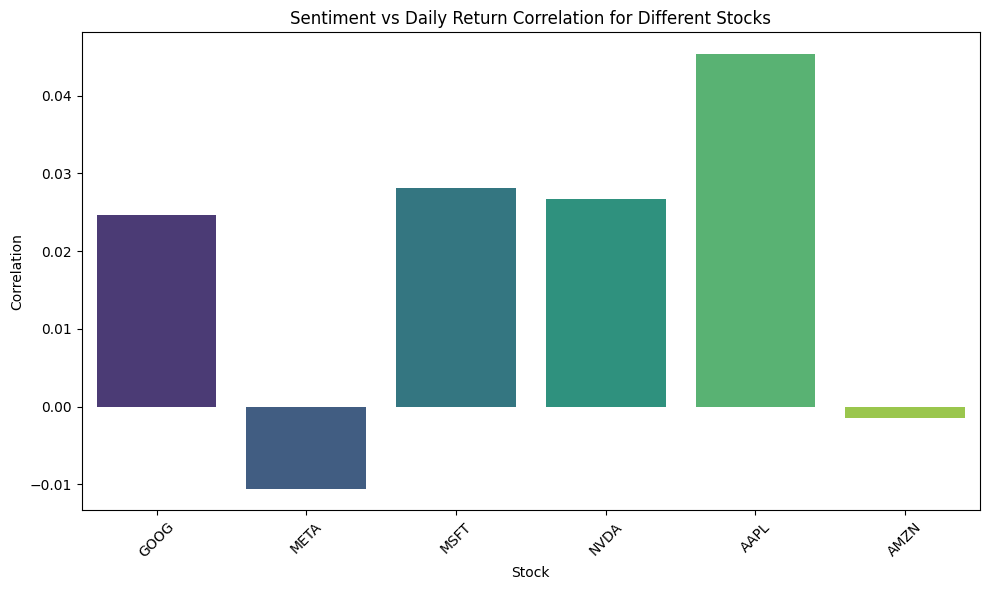

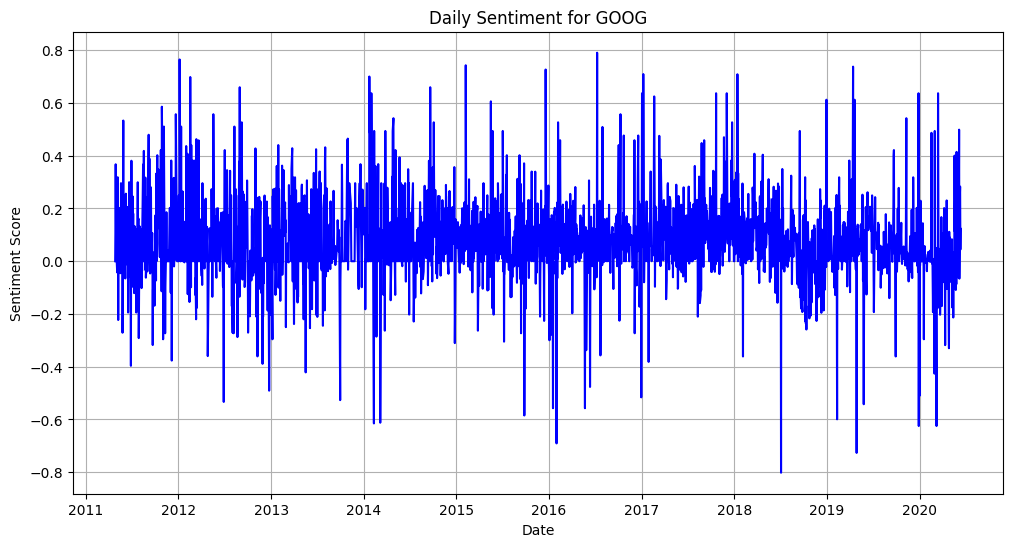

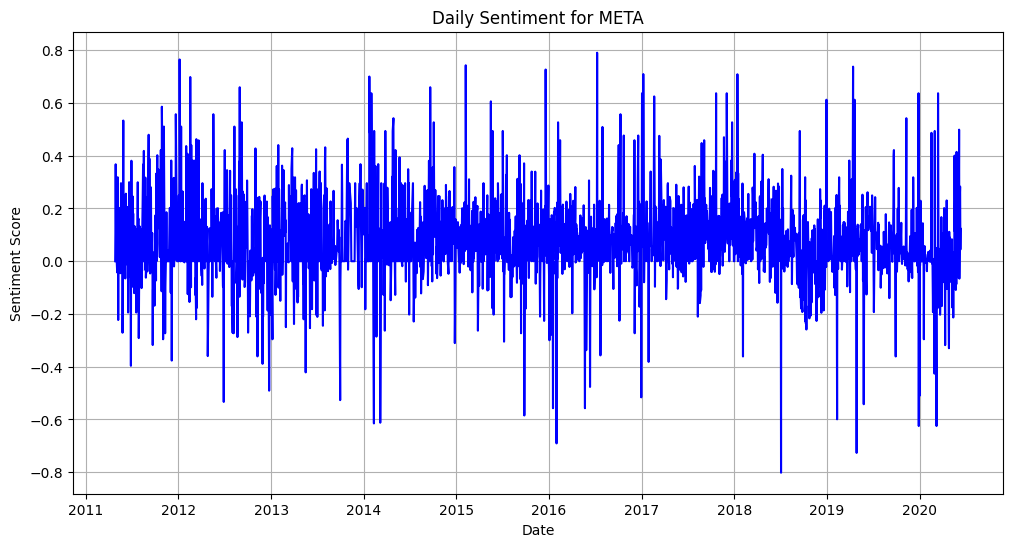

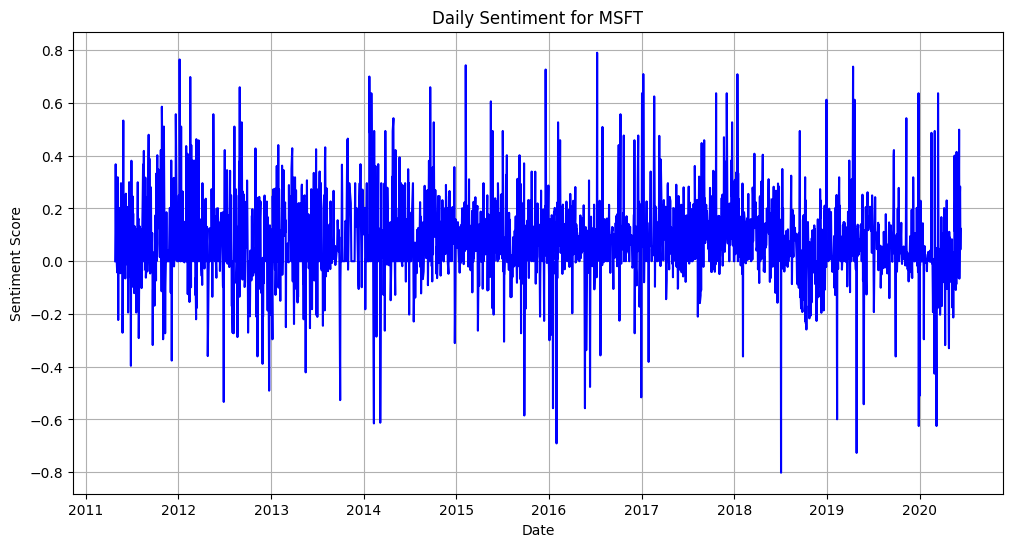

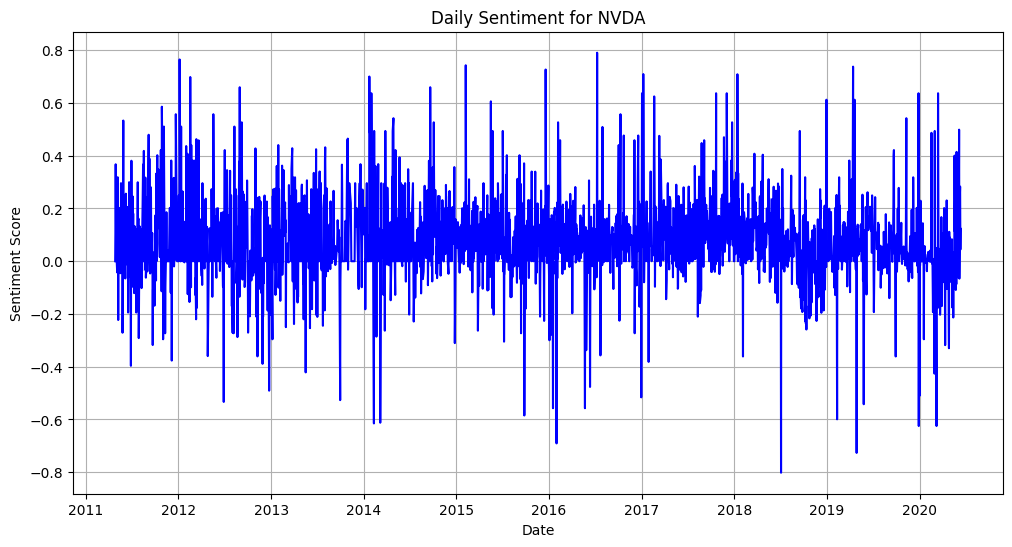

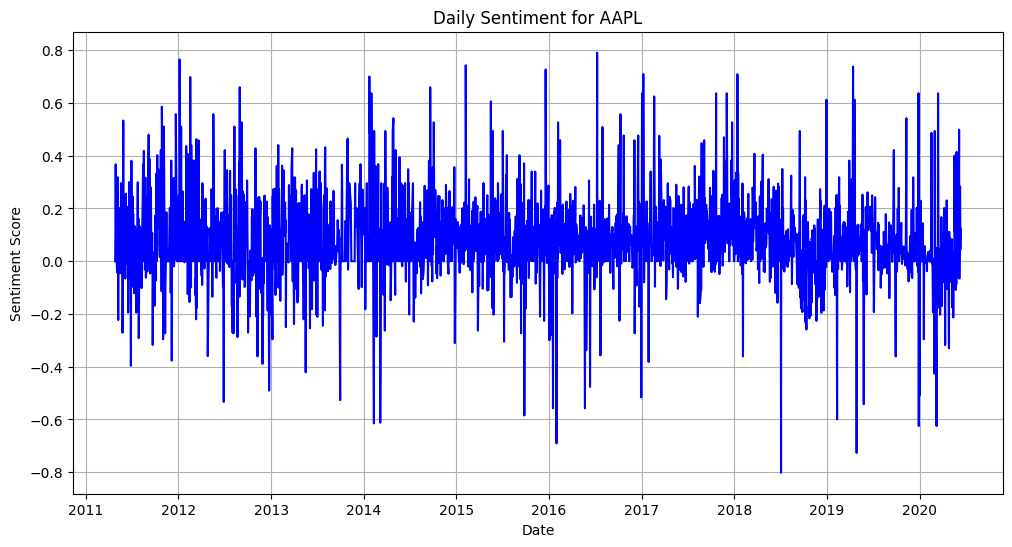

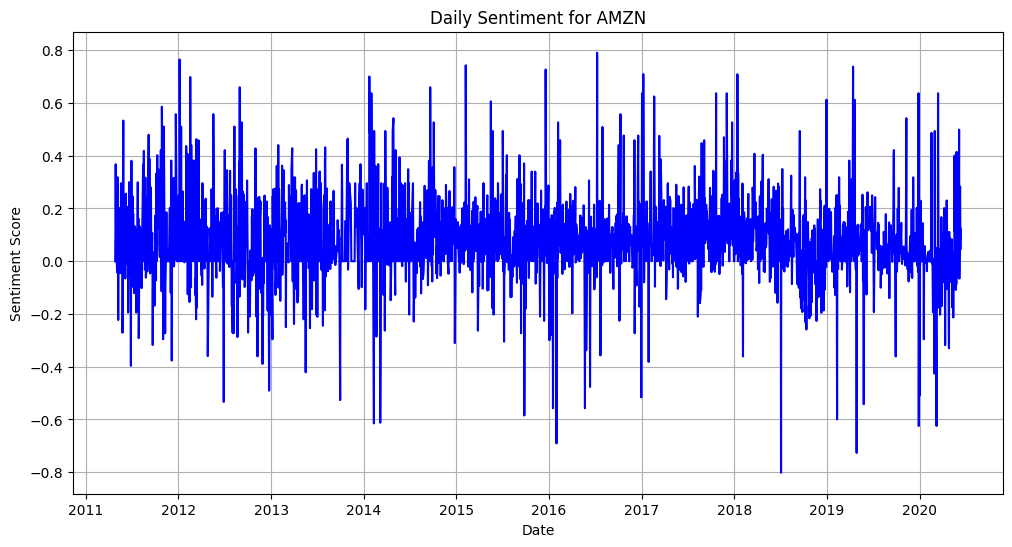

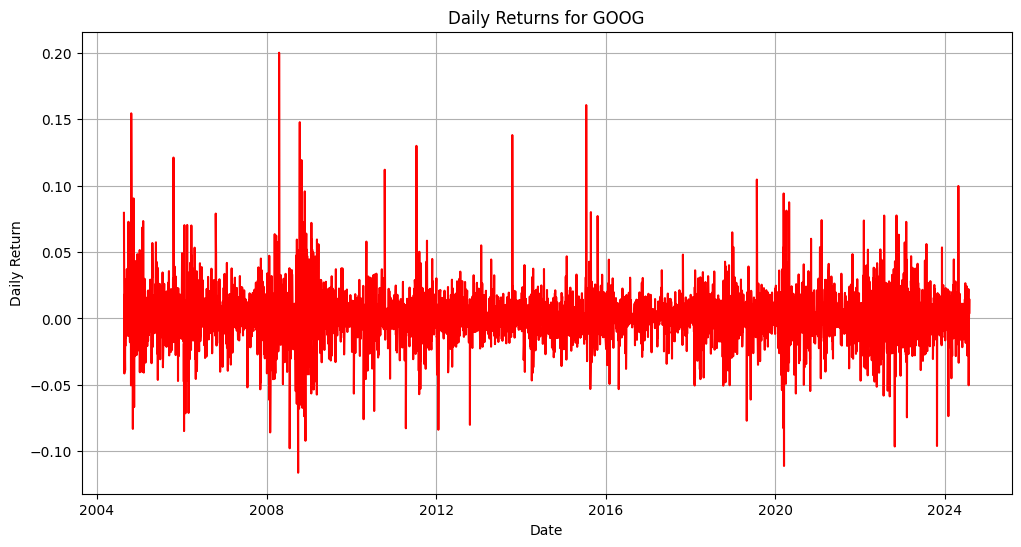

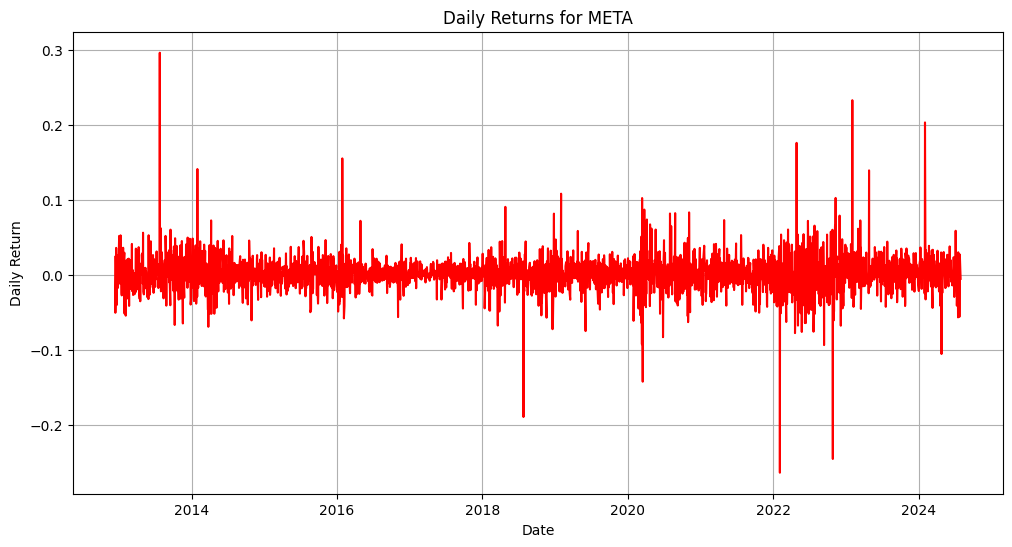

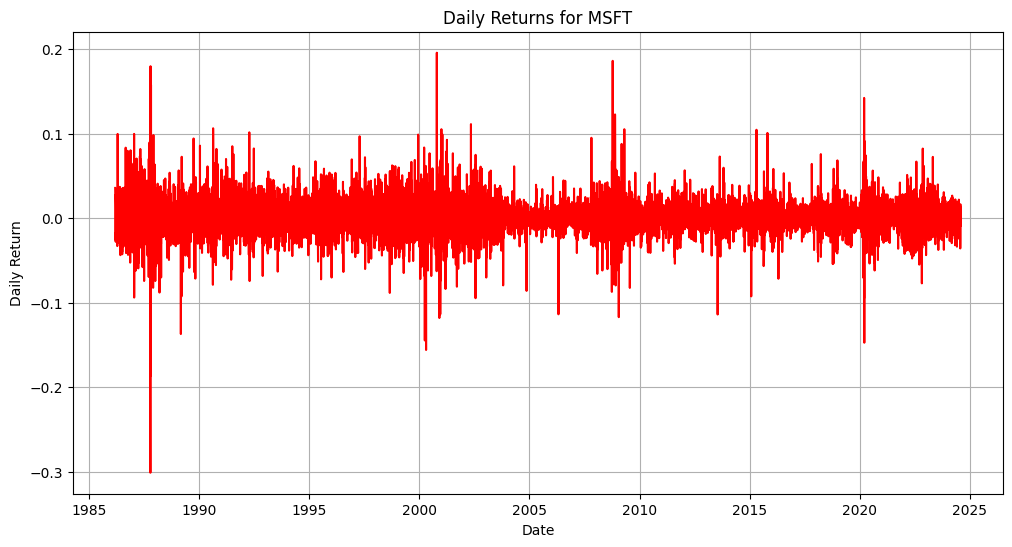

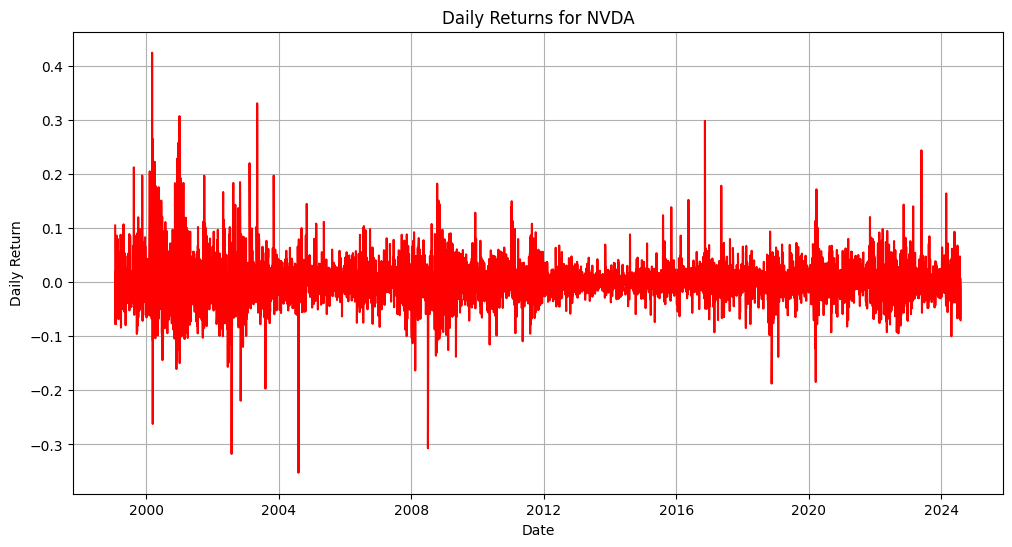

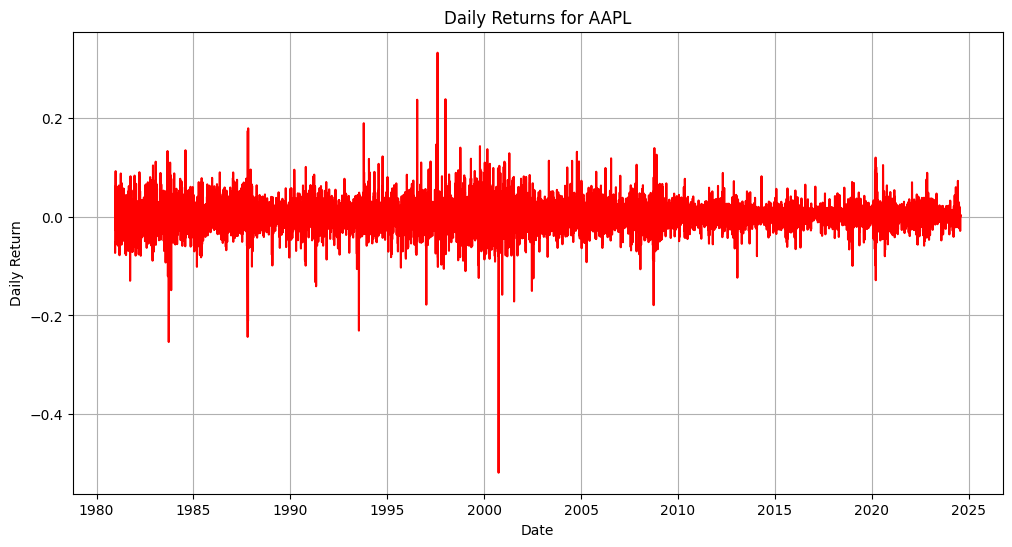

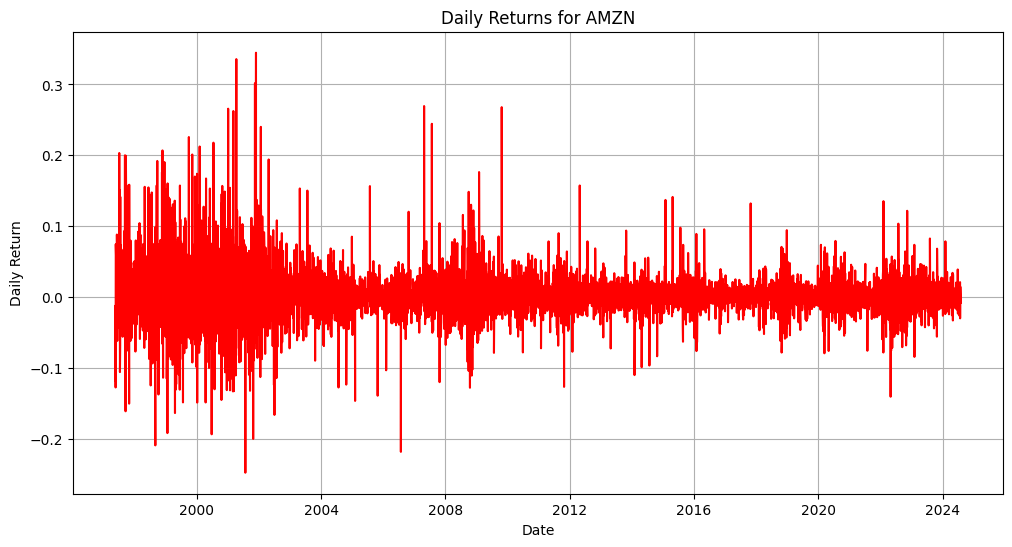

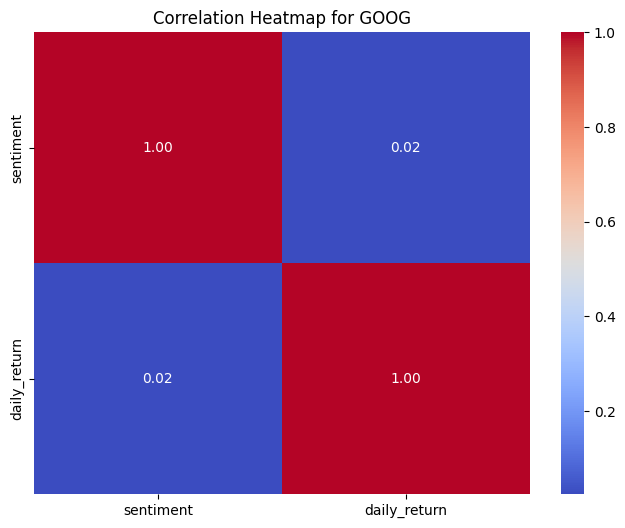

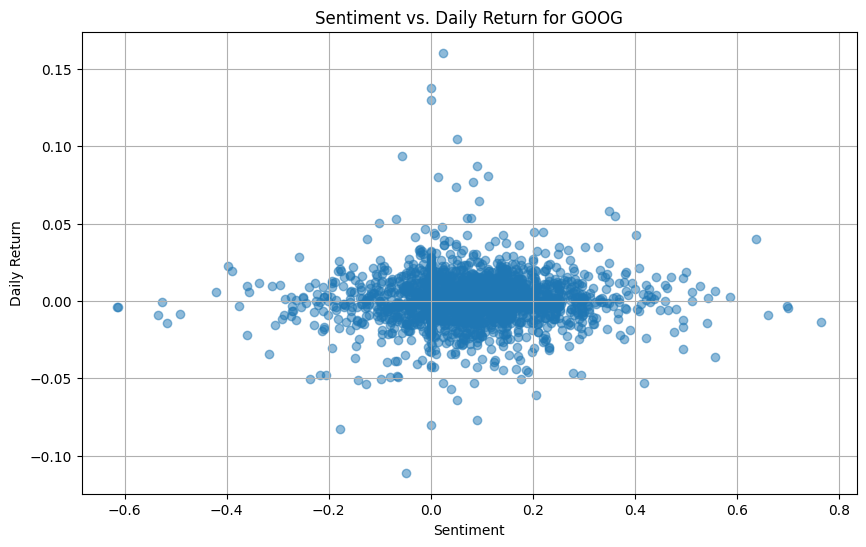

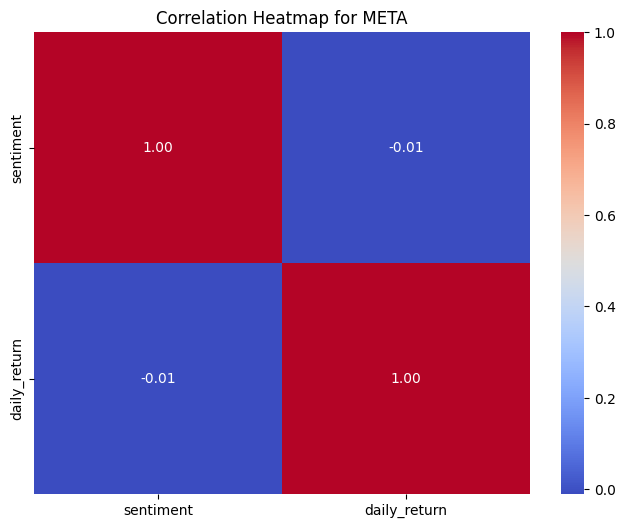

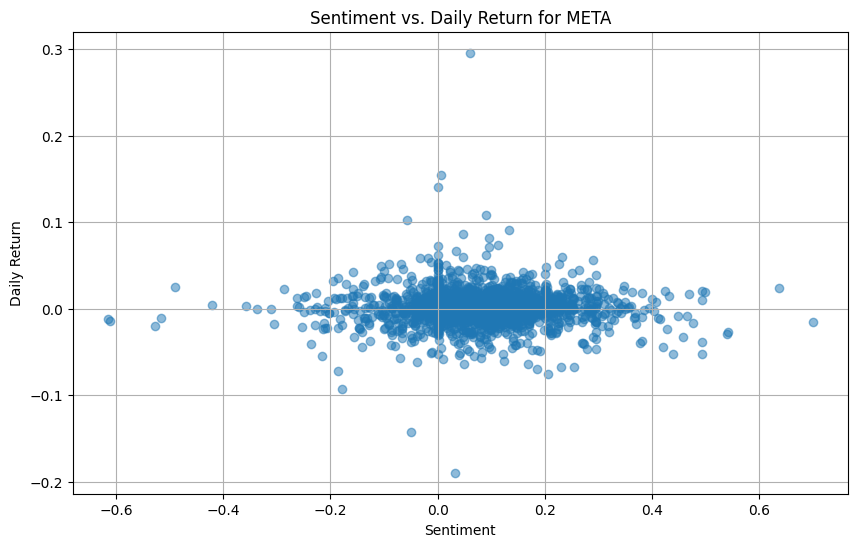

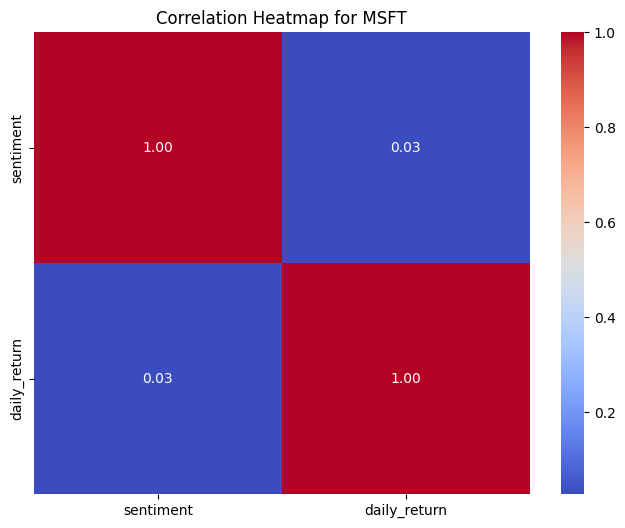

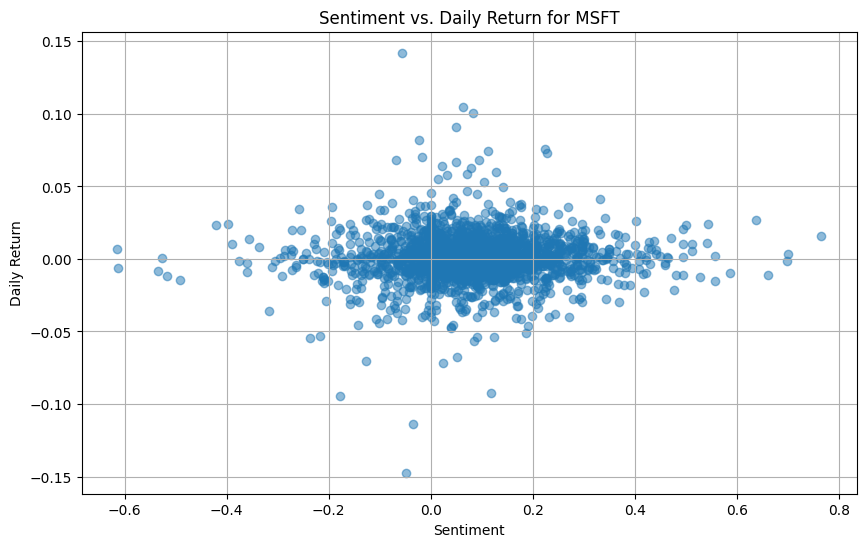

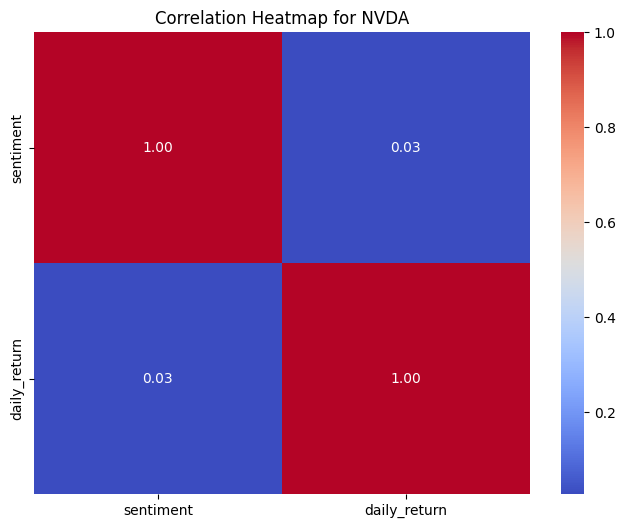

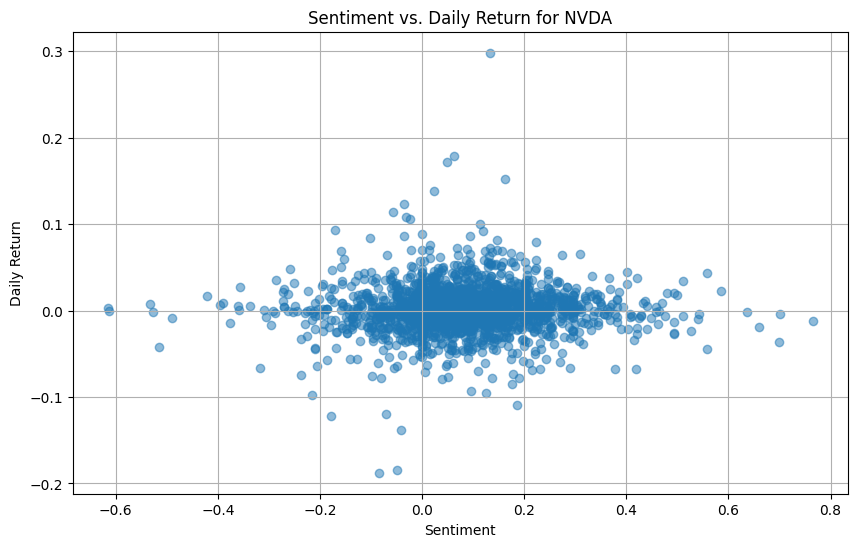

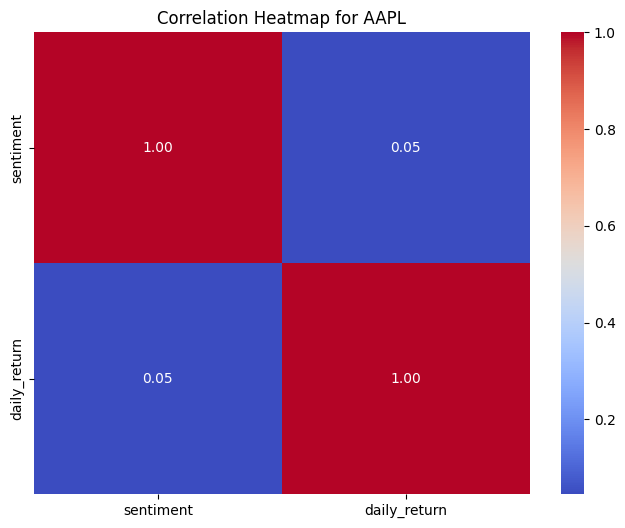

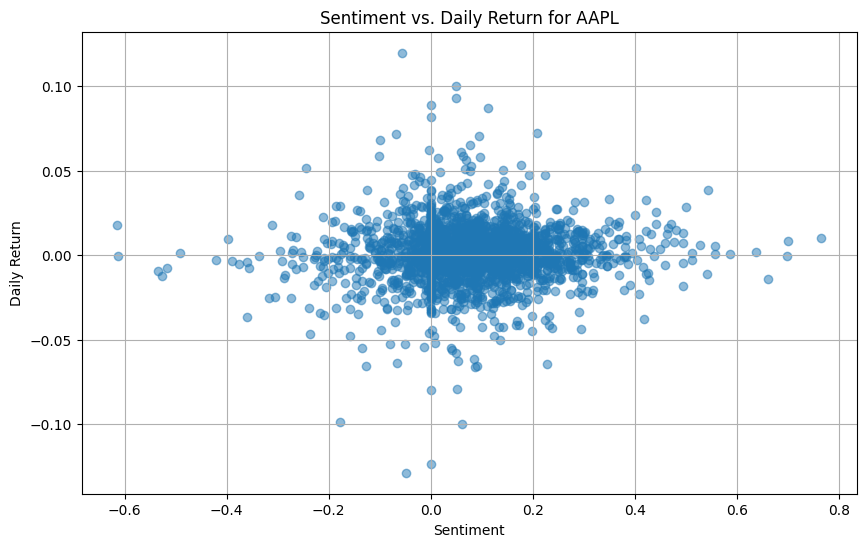

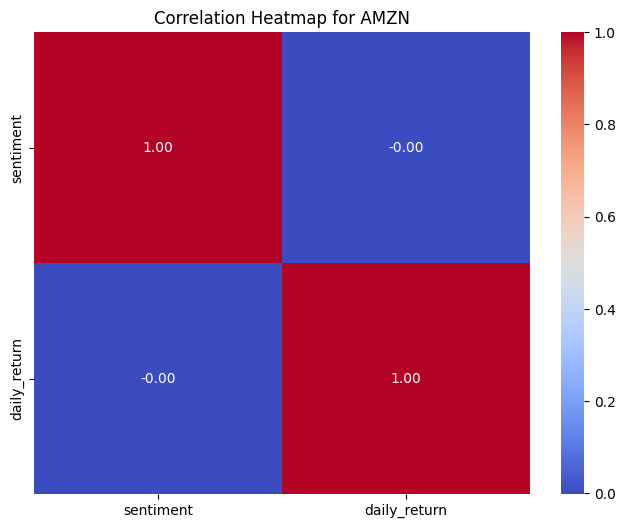

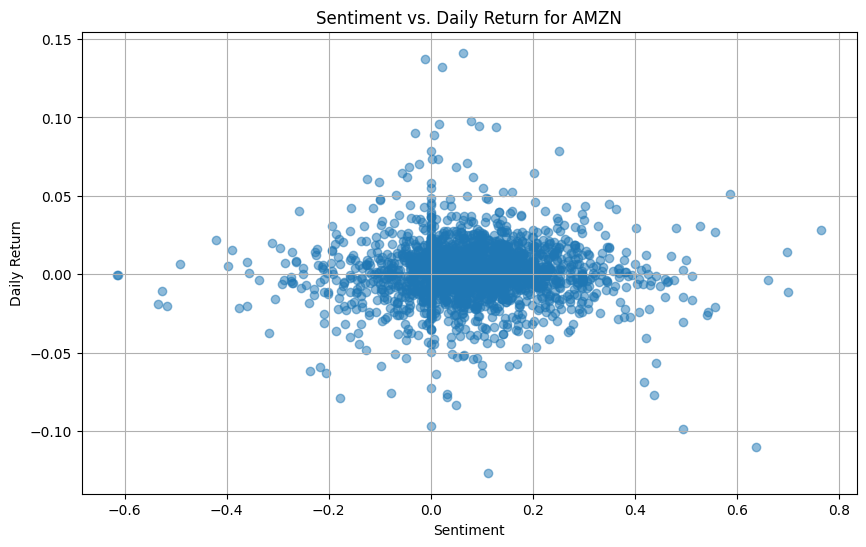

In [4]:
def load_and_prepare_data(stock_file, news_file):
    # Load datasets
    news_df = pd.read_csv(news_file)
    stock_df = pd.read_csv(stock_file)

    # Convert to datetime with coercion for robustness
    news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')
    stock_df['Date'] = pd.to_datetime(stock_df['Date'], errors='coerce')

    # Drop rows where date conversion failed
    news_df = news_df.dropna(subset=['date'])
    stock_df = stock_df.dropna(subset=['Date'])

    # Remove timezone info if needed
    news_df['date'] = news_df['date'].dt.tz_localize(None)
    stock_df['Date'] = stock_df['Date'].dt.tz_localize(None)

    return news_df, stock_df



def analyze_sentiment(news_df):
    analyzer = SentimentIntensityAnalyzer()
    news_df['sentiment'] = news_df['headline'].apply(
        lambda x: analyzer.polarity_scores(str(x))['compound']
    )
    daily_sentiment = news_df.groupby(news_df['date'].dt.date)['sentiment'].mean().reset_index()
    daily_sentiment.rename(columns={'date': 'Date'}, inplace=True)
    return daily_sentiment


def calculate_stock_returns(stock_df):
    stock_df['Date'] = stock_df['Date'].dt.date
    stock_df['daily_return'] = stock_df['Close'].pct_change()
    return stock_df


def merge_and_compute_correlation(sentiment_df, stock_df):
    merged_df = pd.merge(sentiment_df, stock_df, on='Date').dropna(subset=['sentiment', 'daily_return'])
    correlation = merged_df[['sentiment', 'daily_return']].corr().iloc[0, 1]
    return correlation, merged_df


def process_data(stock_file, news_file):
    news_df, stock_df = load_and_prepare_data(stock_file, news_file)
    sentiment_df = analyze_sentiment(news_df)
    stock_df = calculate_stock_returns(stock_df)
    correlation, merged_df = merge_and_compute_correlation(sentiment_df, stock_df)
    return correlation, sentiment_df, stock_df, merged_df


def visualize_summary(correlations):
    summary_df = pd.DataFrame(list(correlations.items()), columns=['Stock', 'Correlation'])
    print("\nSummary of Correlations:")
    print(summary_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Stock', y='Correlation', data=summary_df, palette='viridis')
    plt.title('Sentiment vs Daily Return Correlation for Different Stocks')
    plt.xlabel('Stock')
    plt.ylabel('Correlation')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    return summary_df


def plot_time_series(sentiments, returns):
    for stock in sentiments:
        plt.figure(figsize=(12, 6))
        plt.plot(sentiments[stock]['Date'], sentiments[stock]['sentiment'], color='blue')
        plt.title(f'Daily Sentiment for {stock}')
        plt.xlabel('Date')
        plt.ylabel('Sentiment Score')
        plt.grid(True)
        plt.show()

    for stock in returns:
        plt.figure(figsize=(12, 6))
        plt.plot(returns[stock]['Date'], returns[stock]['daily_return'], color='red')
        plt.title(f'Daily Returns for {stock}')
        plt.xlabel('Date')
        plt.ylabel('Daily Return')
        plt.grid(True)
        plt.show()


def plot_correlation_analysis(merged_data_dict):
    for stock, merged_df in merged_data_dict.items():
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            merged_df[['sentiment', 'daily_return']].corr(),
            annot=True, cmap='coolwarm', fmt='.2f'
        )
        plt.title(f'Correlation Heatmap for {stock}')
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.scatter(merged_df['sentiment'], merged_df['daily_return'], alpha=0.5)
        plt.title(f'Sentiment vs. Daily Return for {stock}')
        plt.xlabel('Sentiment')
        plt.ylabel('Daily Return')
        plt.grid(True)
        plt.show()


# Main execution
if __name__ == '__main__':
    stock_files = {
        'GOOG': '../data/GOOG_historical_data.csv',
        'META': '../data/META_historical_data.csv',
        'MSFT': '../data/MSFT_historical_data.csv',
        'NVDA': '../data/NVDA_historical_data.csv',
        'AAPL': '../data/AAPL_historical_data.csv',
        'AMZN': '../data/AMZN_historical_data.csv',
    }

    news_file = '../data/raw_analyst_ratings.csv'

    results = {}
    sentiment_data = {}
    returns_data = {}
    merged_data_dict = {}

    for stock, file in stock_files.items():
        corr, sentiment_df, stock_df, merged_df = process_data(file, news_file)
        results[stock] = corr
        sentiment_data[stock] = sentiment_df
        returns_data[stock] = stock_df
        merged_data_dict[stock] = merged_df

    visualize_summary(results)
    plot_time_series(sentiment_data, returns_data)
    plot_correlation_analysis(merged_data_dict)


In [5]:
def plot_correlation_analysis(merged_data_dict):
    for stock, merged_data in merged_data_dict.items():
        # Plot correlation heatmap
        fig, ax = plt.subplots(figsize=(8, 6))
        corr_matrix = merged_data[['sentiment', 'daily_return']].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
        ax.set_title(f'Correlation Heatmap for {stock}')
        plt.tight_layout()
        plt.show()

        # Plot scatter of sentiment vs. daily return
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(merged_data['sentiment'], merged_data['daily_return'], alpha=0.5, color='purple')
        ax.set_title(f'Sentiment vs. Daily Stock Return for {stock}')
        ax.set_xlabel('Sentiment')
        ax.set_ylabel('Daily Return')
        ax.grid(True)
        plt.tight_layout()
        plt.show()


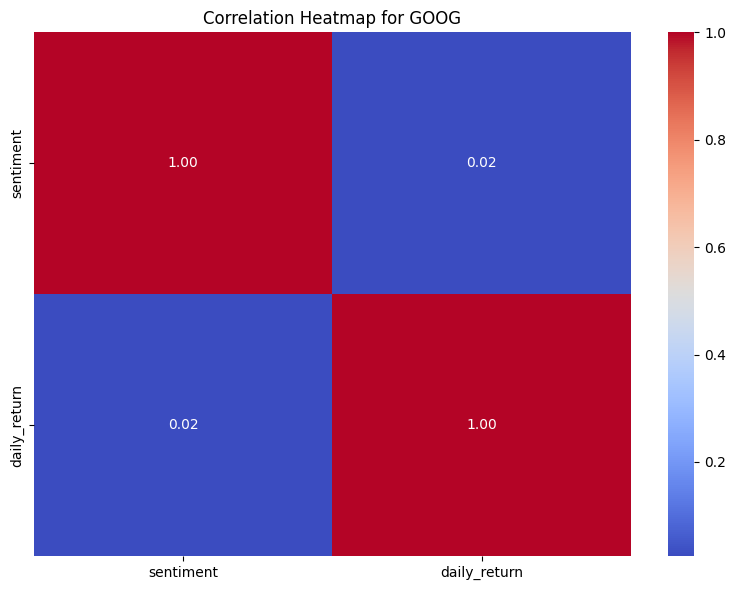

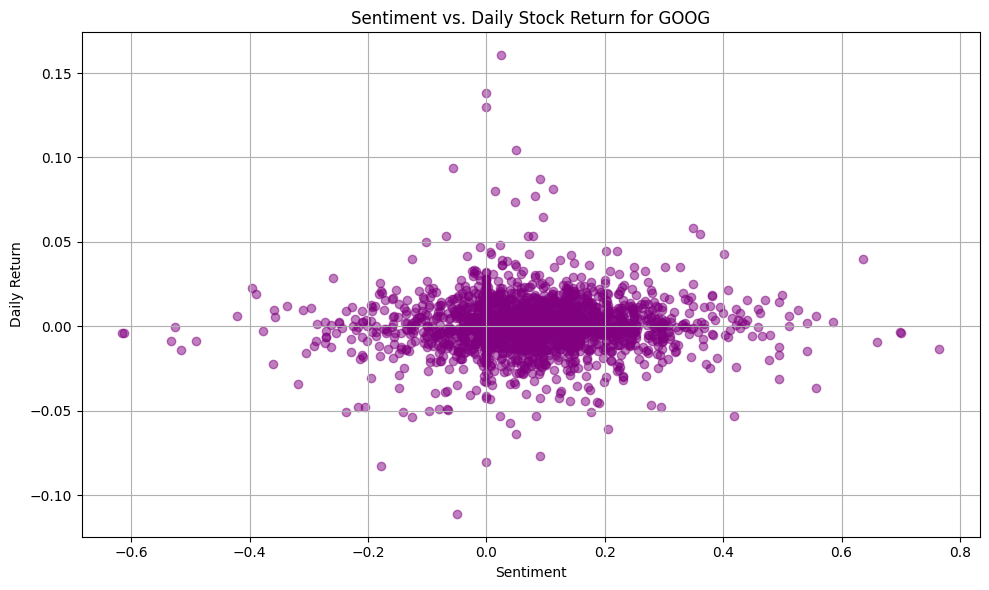

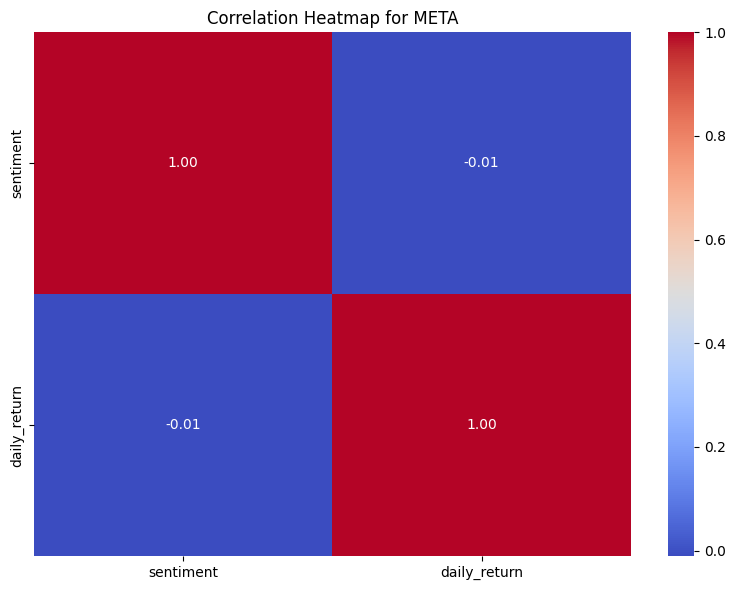

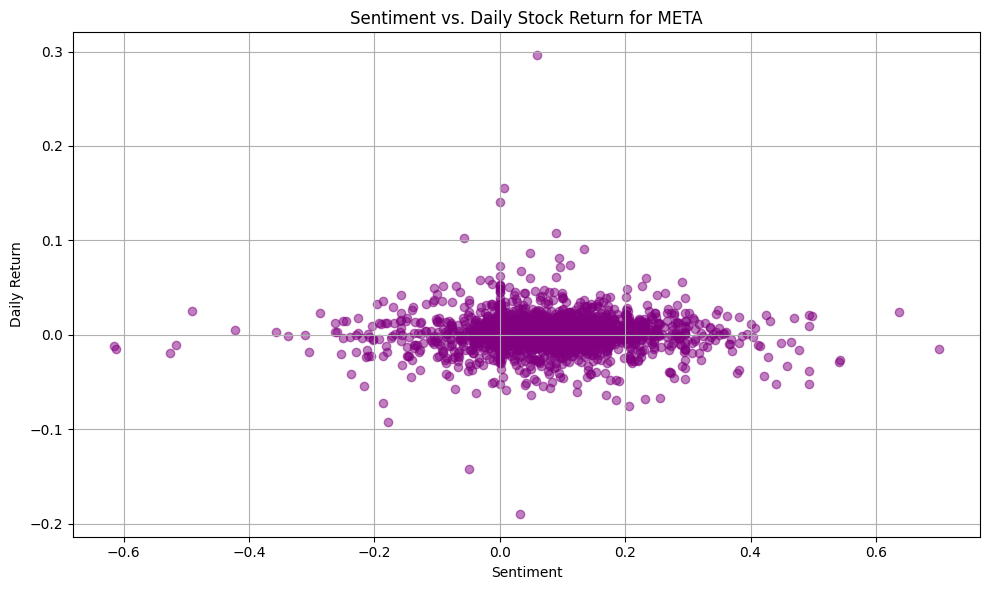

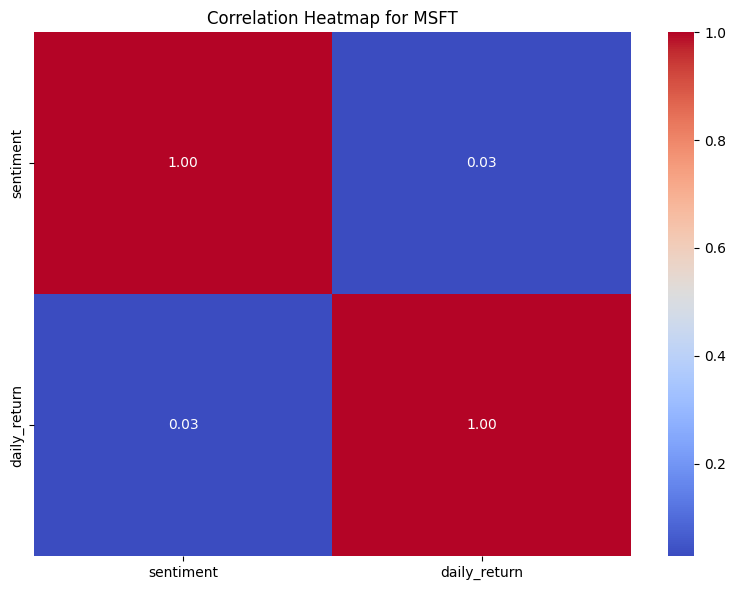

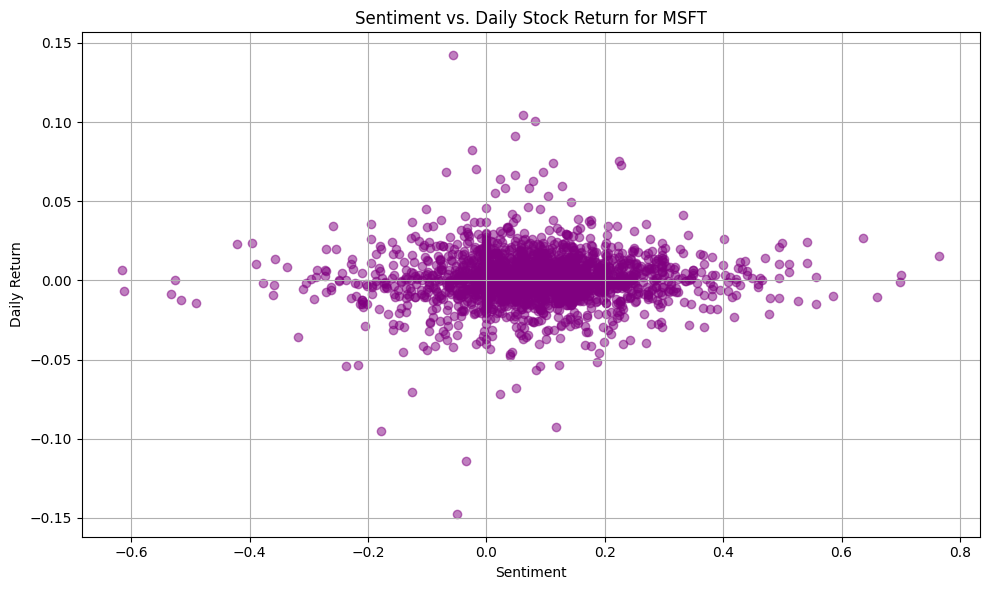

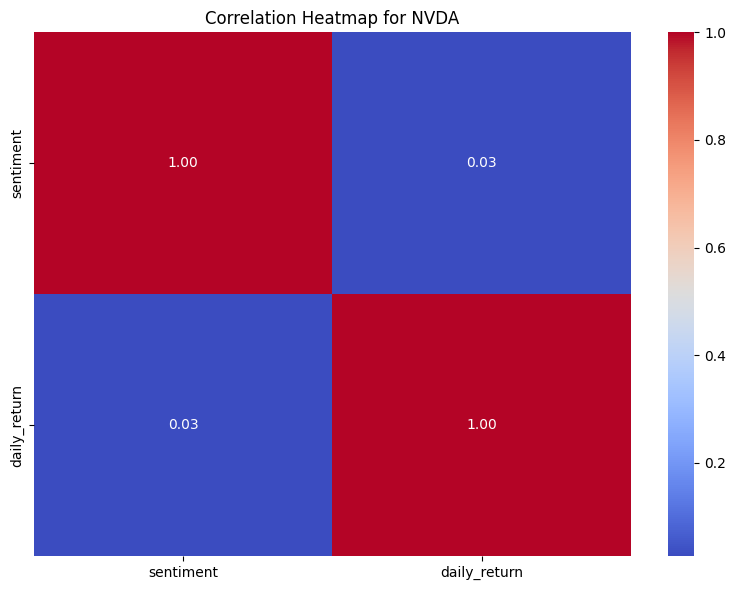

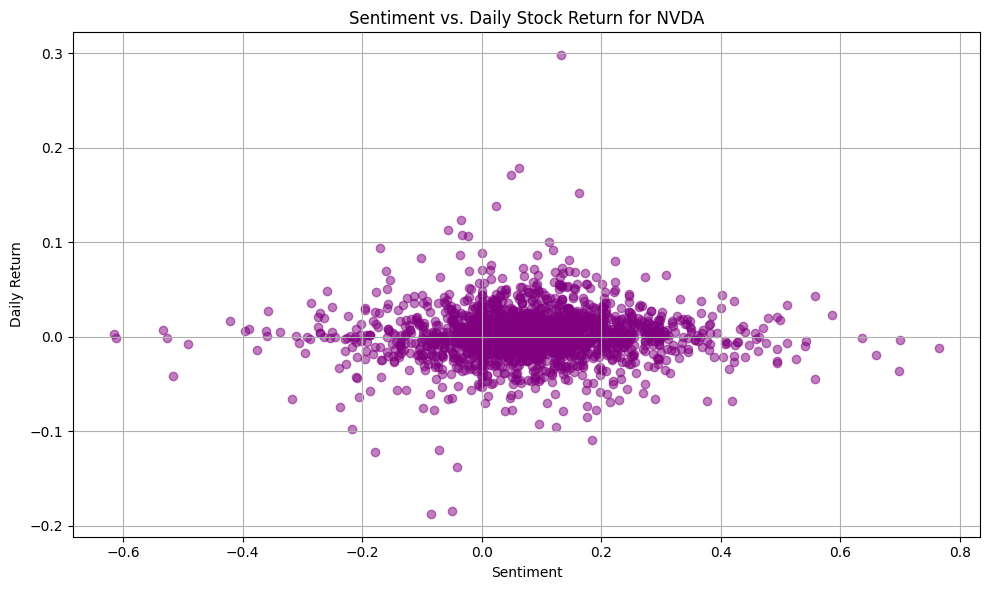

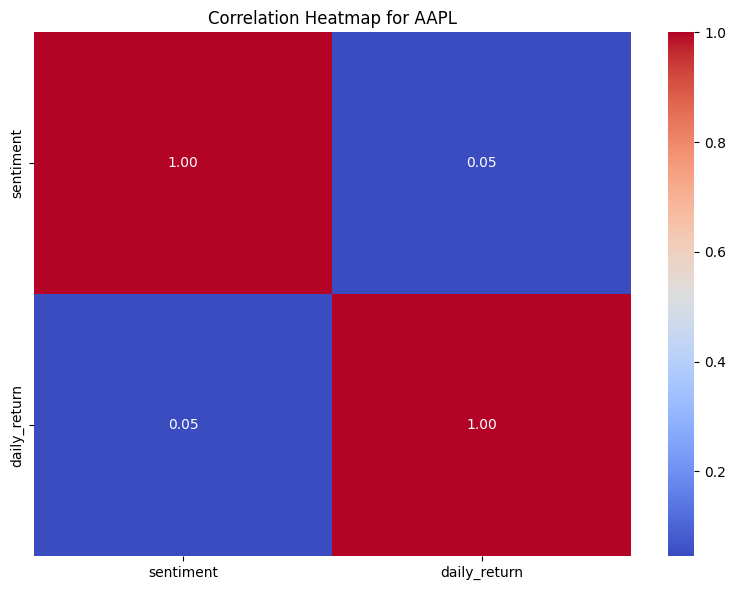

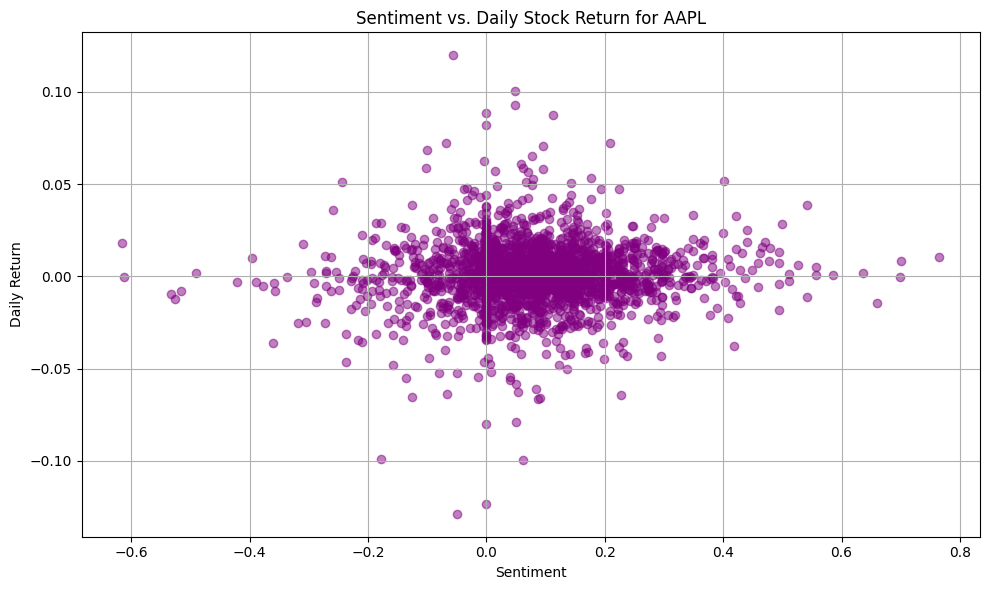

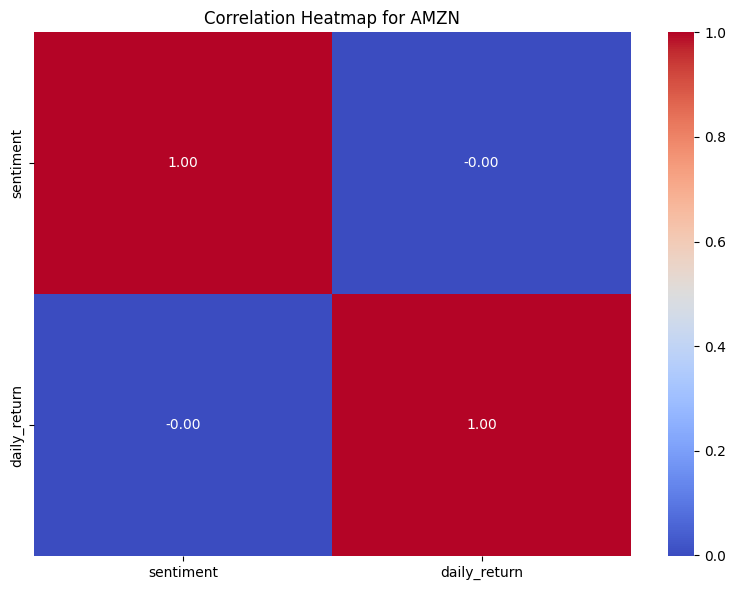

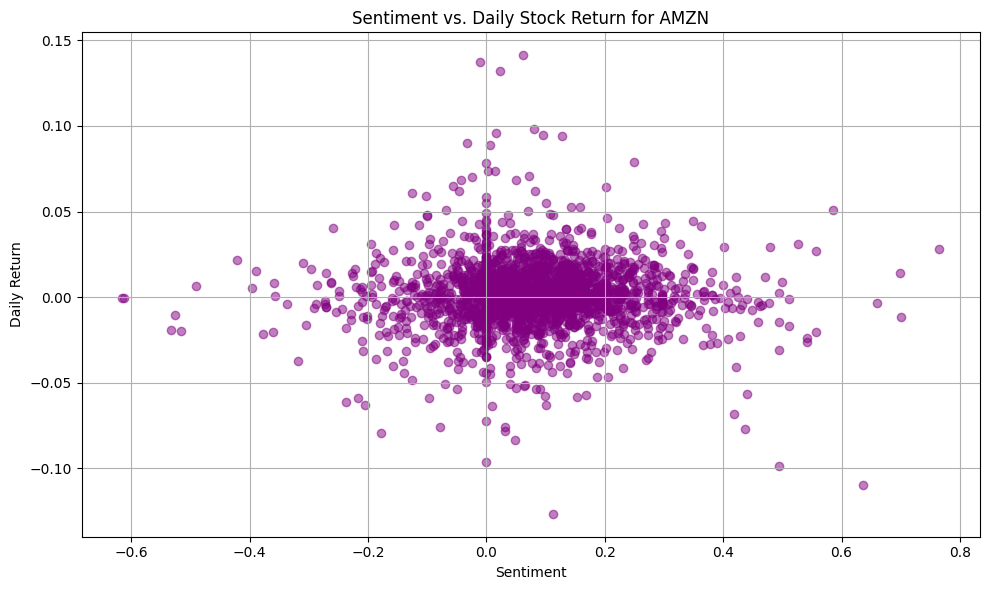

In [6]:
plot_correlation_analysis(merged_data_dict)



Summary of Correlations:
   Stock  Correlation
0  GOOG          NaN
1  META          NaN
2  MSFT          NaN
3  NVDA          NaN
4  AAPL          NaN
5  AMZN          NaN


C:\Users\smith\AppData\Local\Temp\ipykernel_5964\3317987187.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Stock', y='Correlation', data=summary_df, palette='viridis')


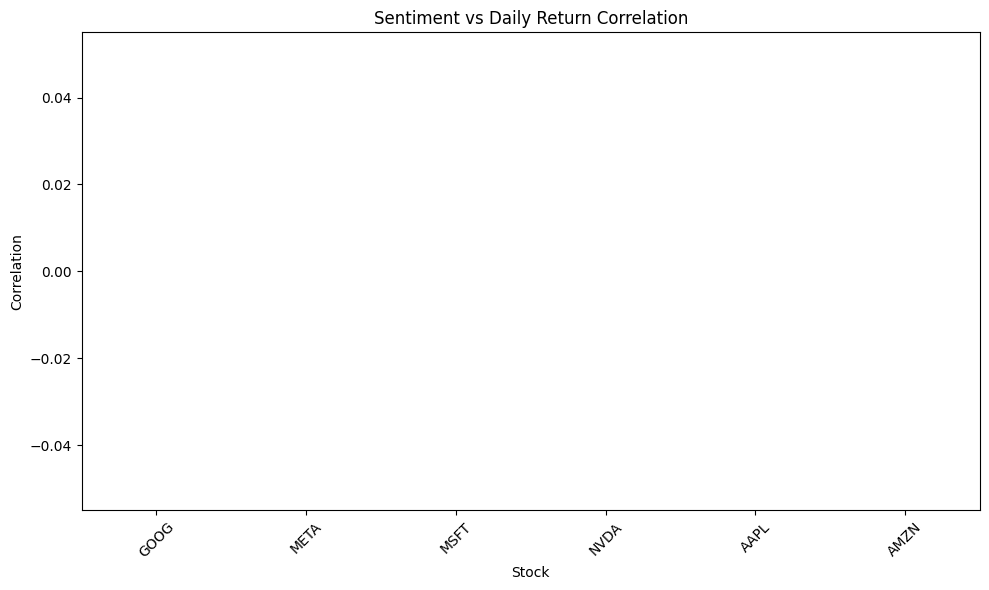

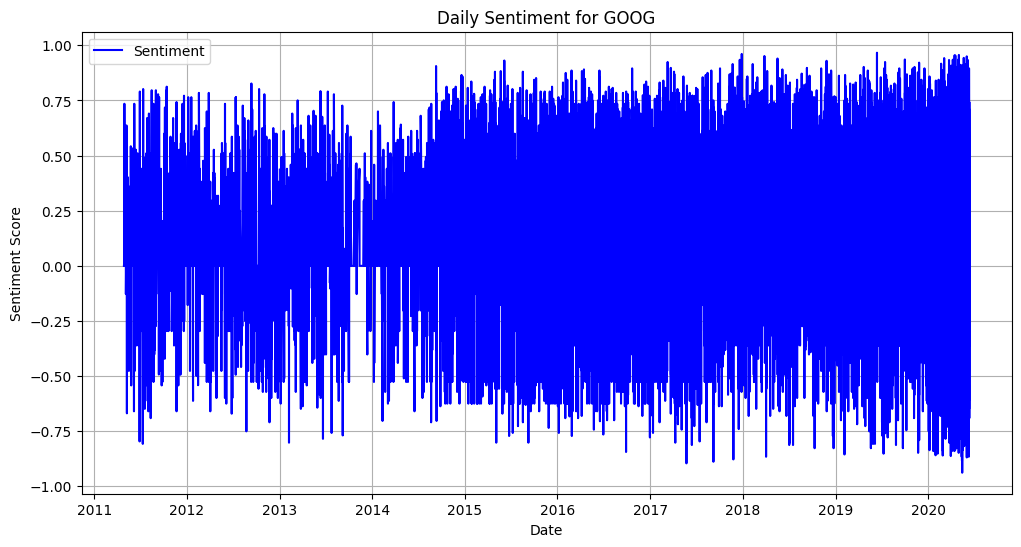

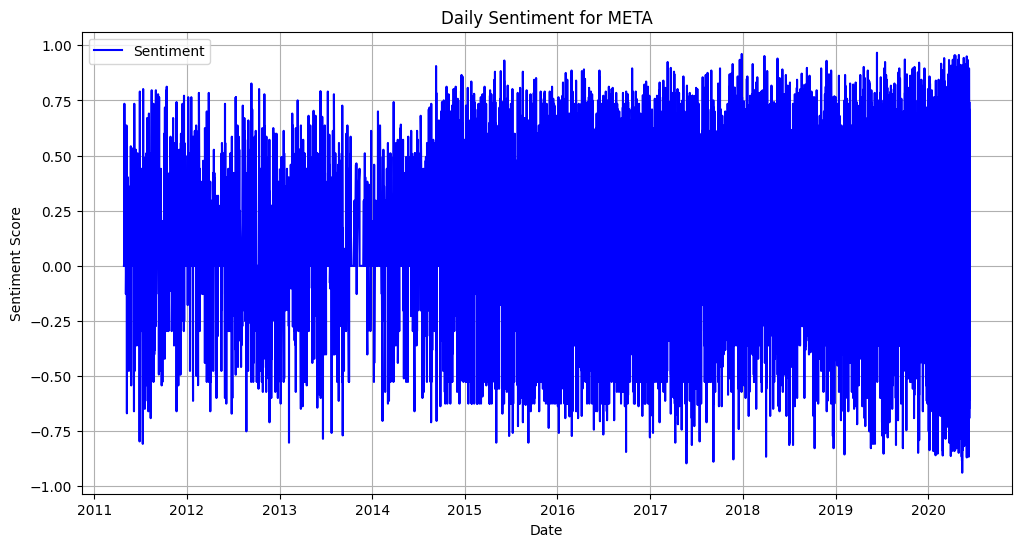

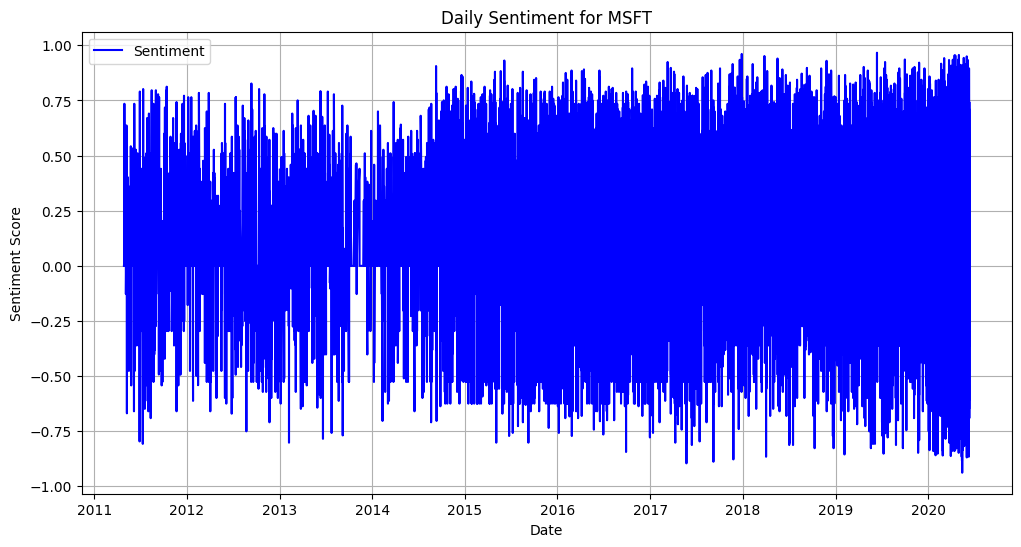

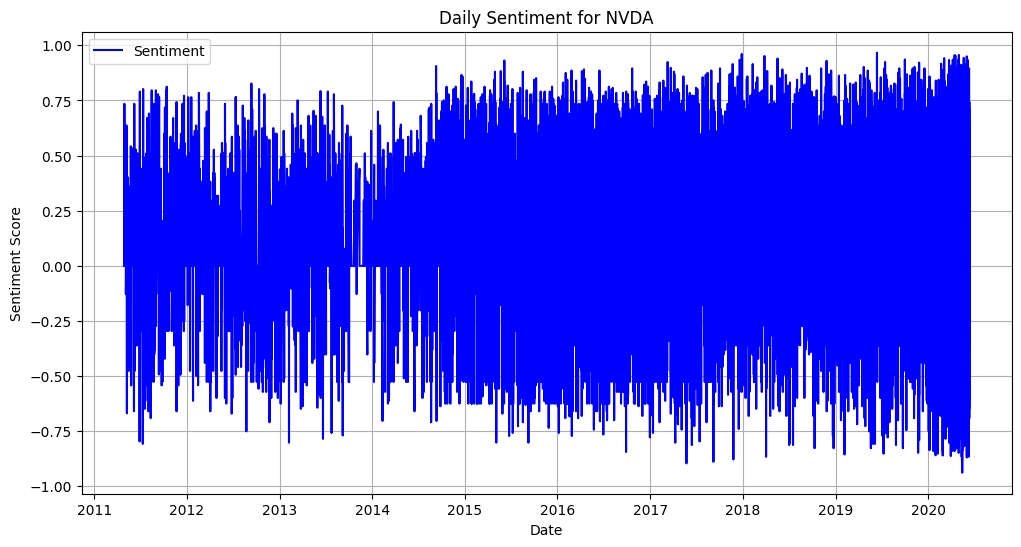

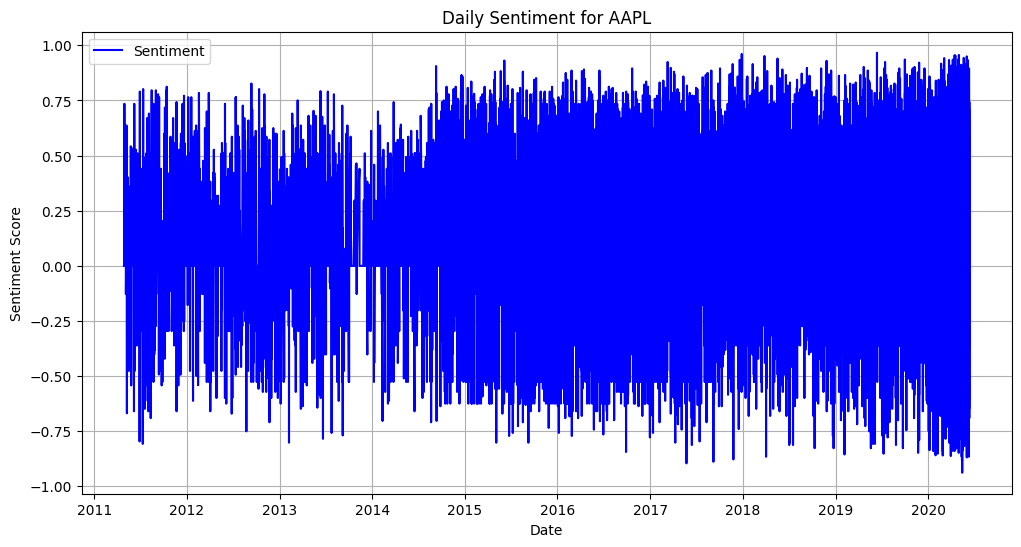

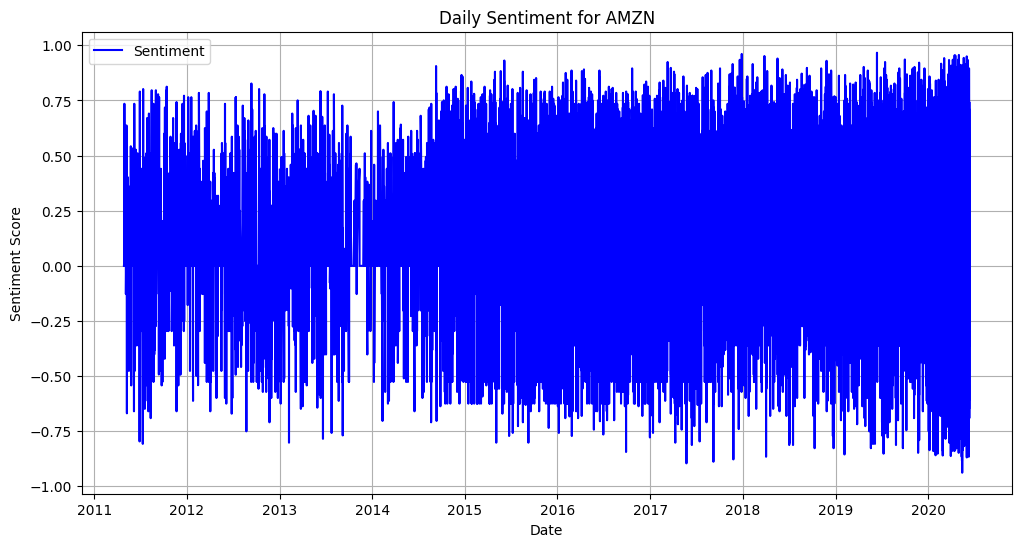

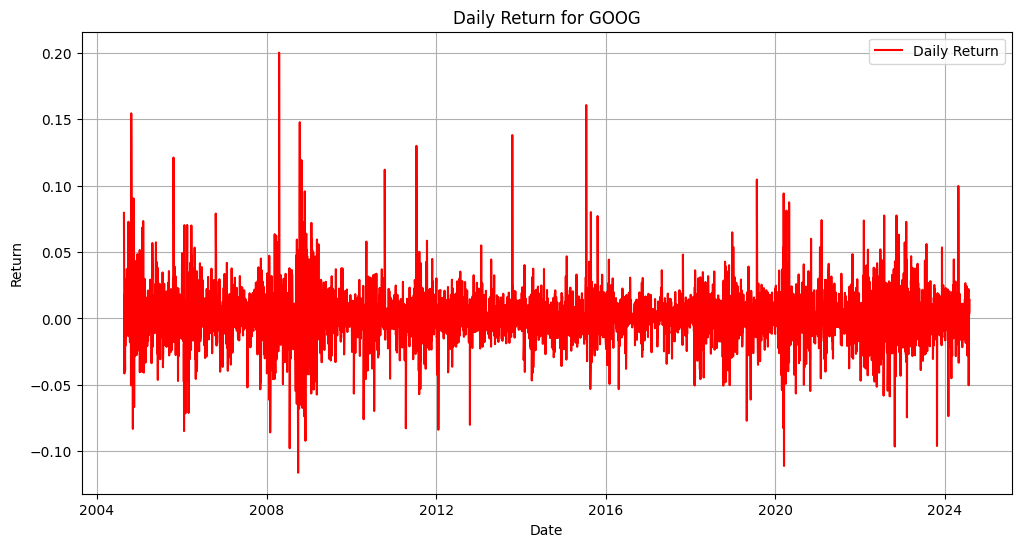

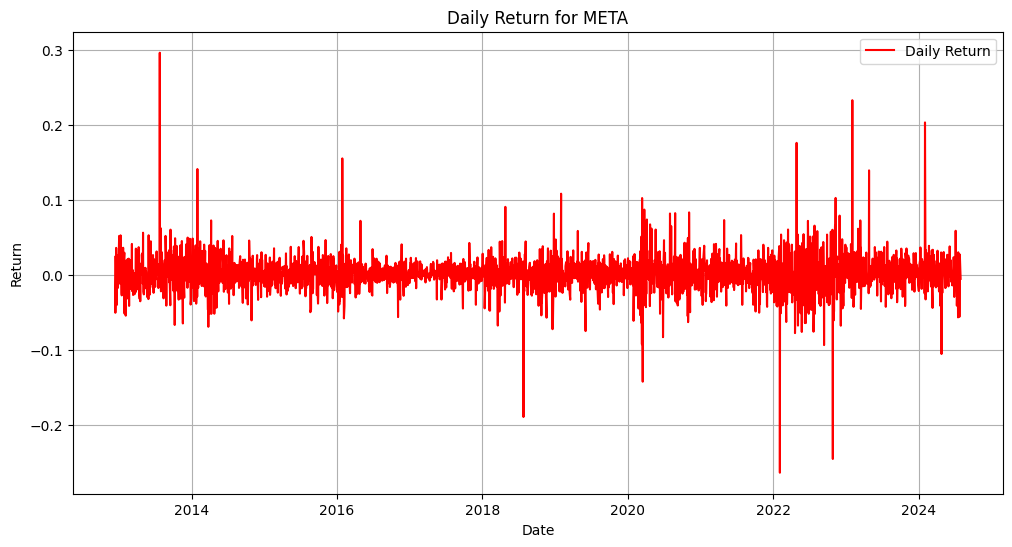

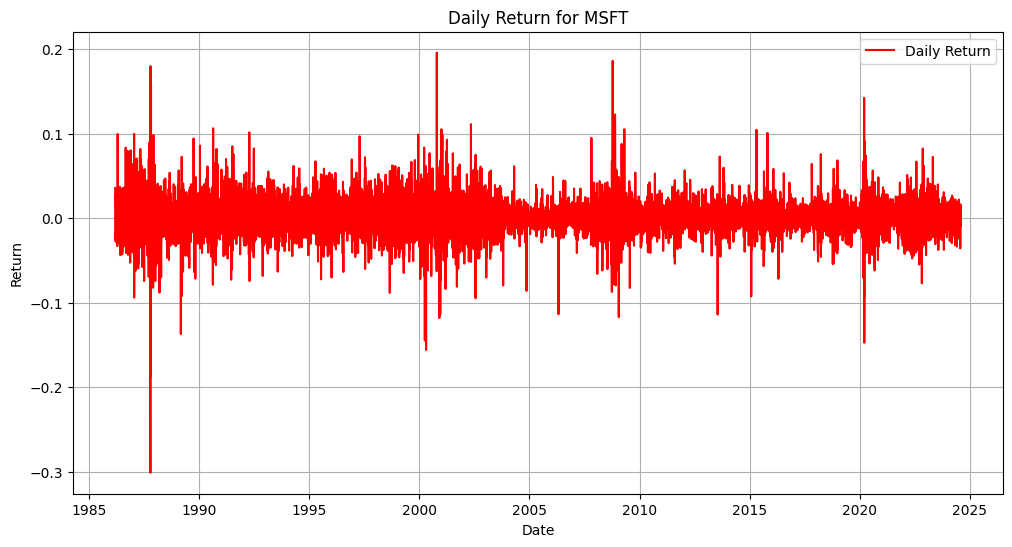

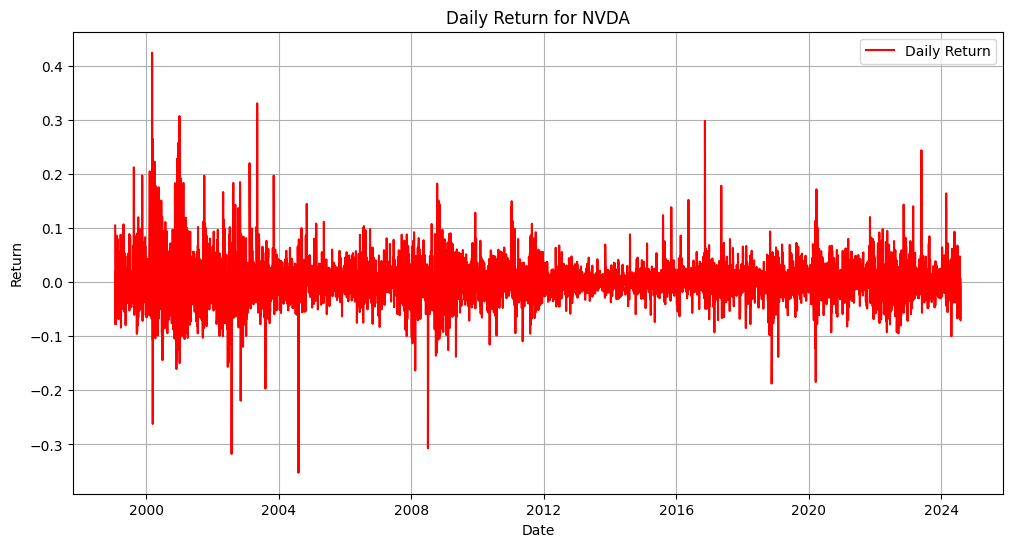

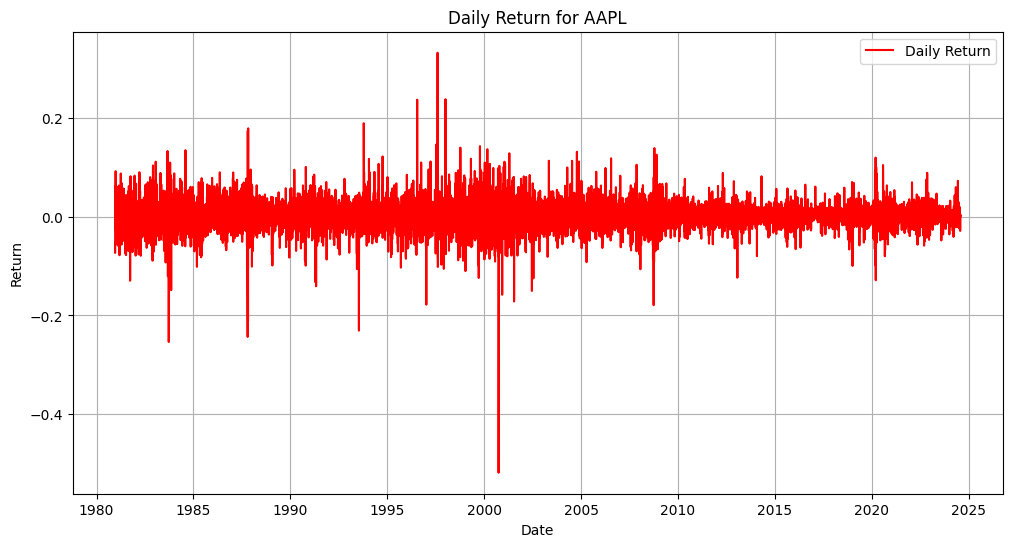

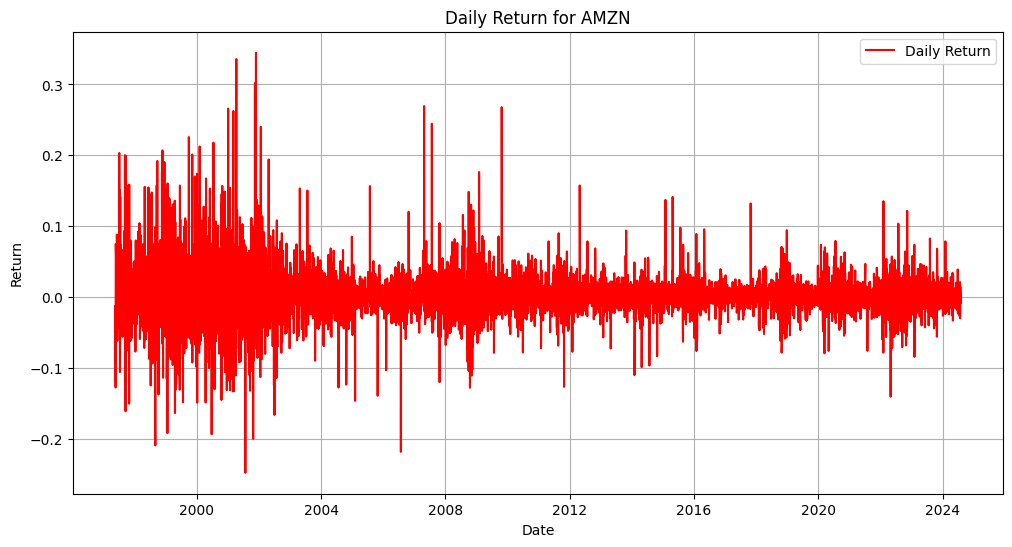

d:\KAIM\Week0_12\Week_1\AIM_Week_1\.venv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
d:\KAIM\Week0_12\Week_1\AIM_Week_1\.venv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


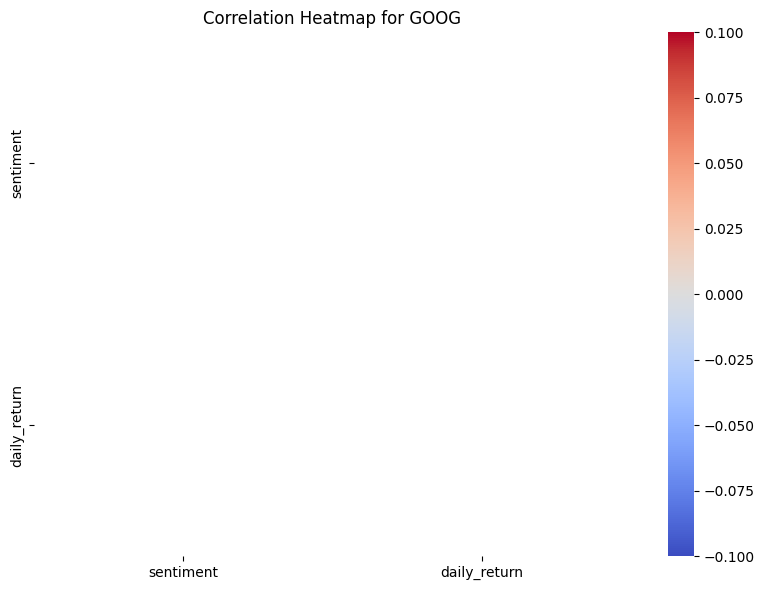

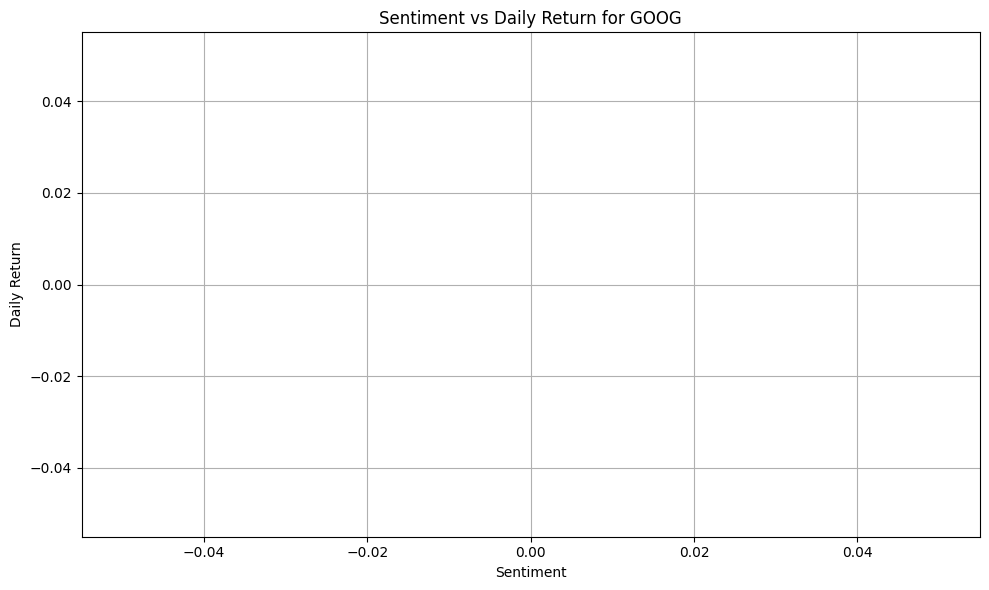

d:\KAIM\Week0_12\Week_1\AIM_Week_1\.venv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
d:\KAIM\Week0_12\Week_1\AIM_Week_1\.venv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


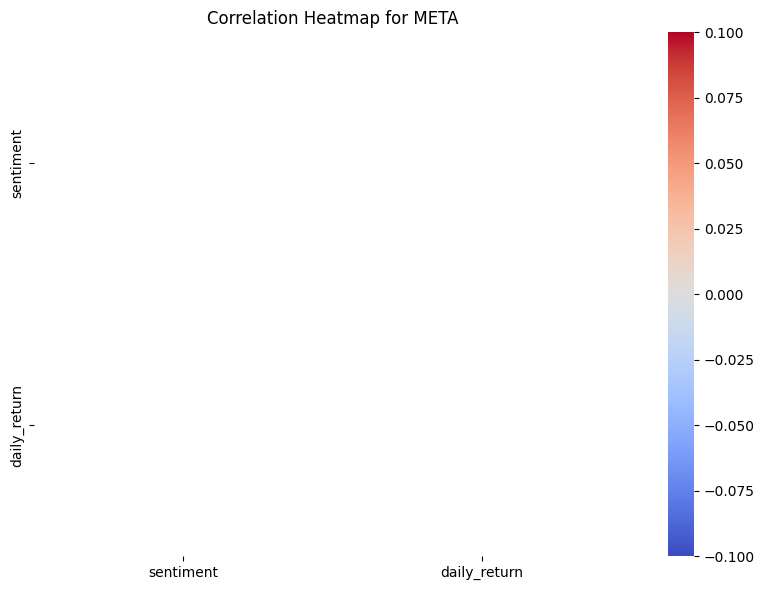

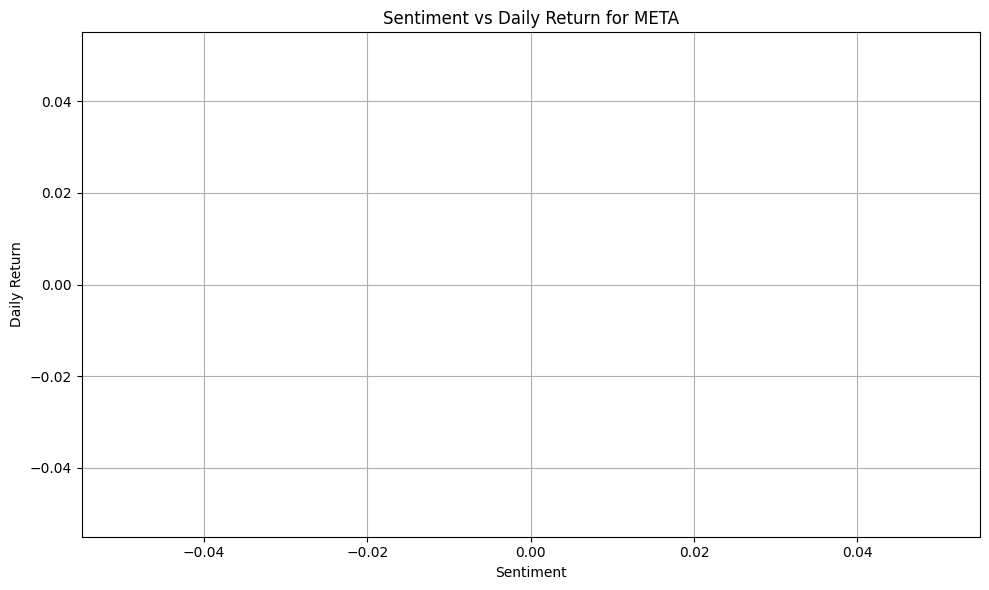

d:\KAIM\Week0_12\Week_1\AIM_Week_1\.venv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
d:\KAIM\Week0_12\Week_1\AIM_Week_1\.venv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


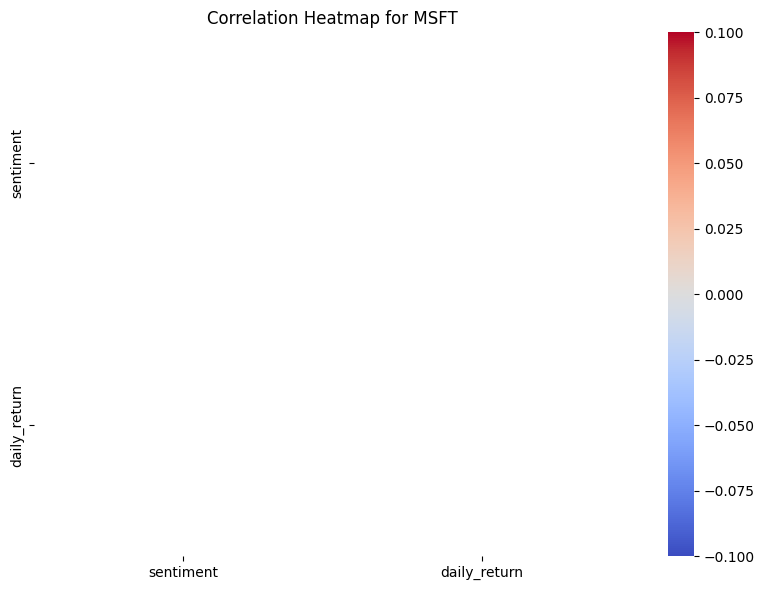

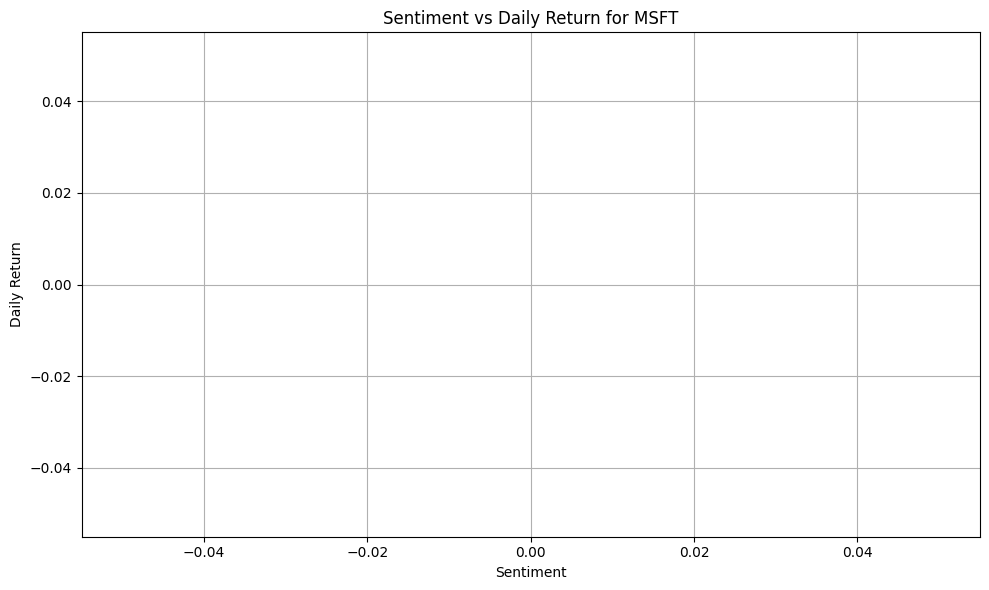

d:\KAIM\Week0_12\Week_1\AIM_Week_1\.venv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
d:\KAIM\Week0_12\Week_1\AIM_Week_1\.venv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


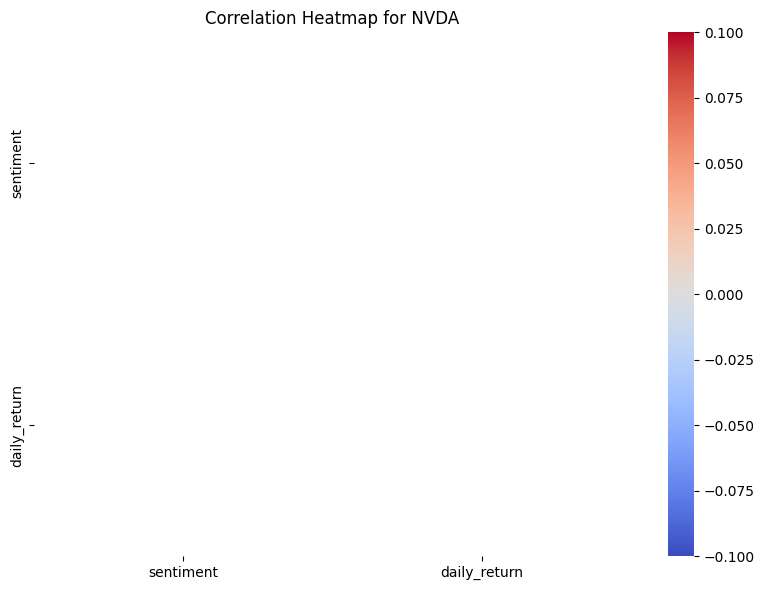

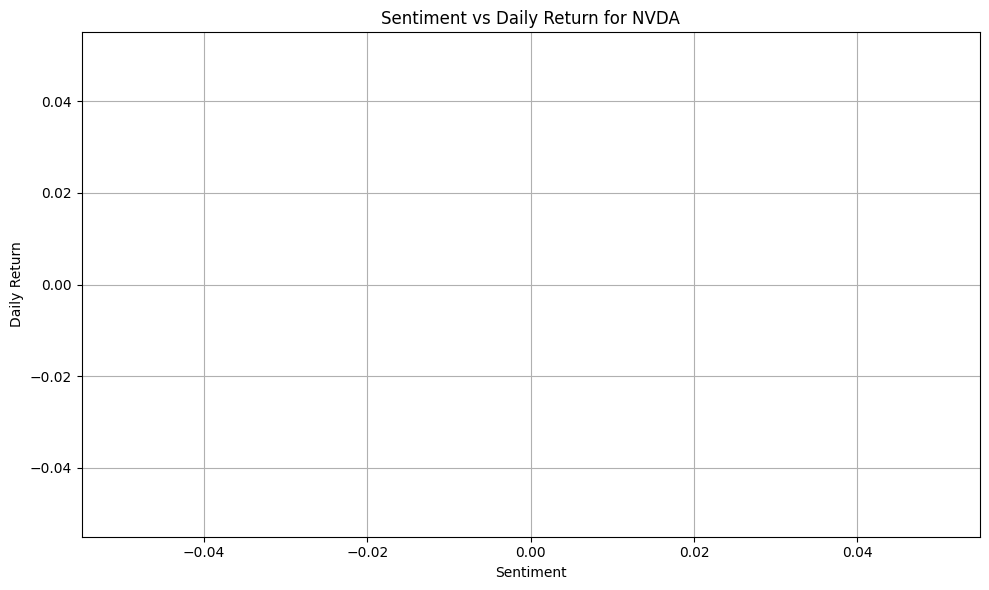

d:\KAIM\Week0_12\Week_1\AIM_Week_1\.venv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
d:\KAIM\Week0_12\Week_1\AIM_Week_1\.venv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


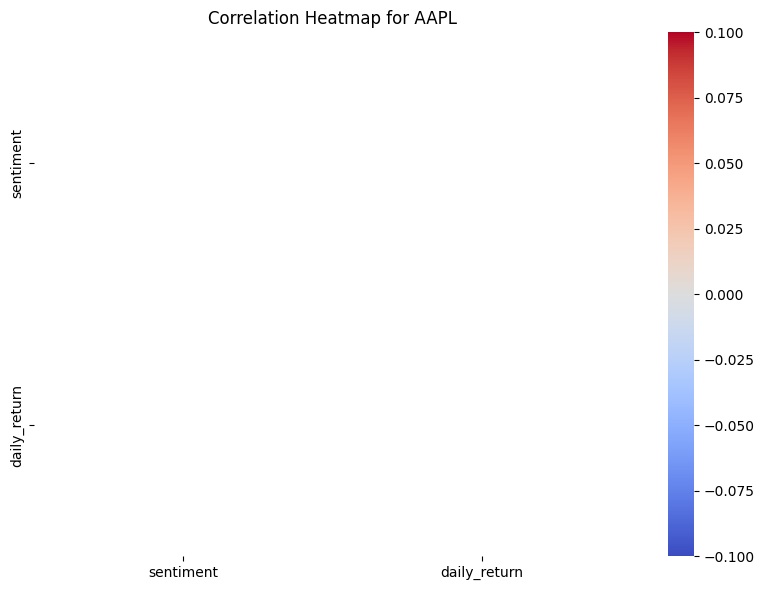

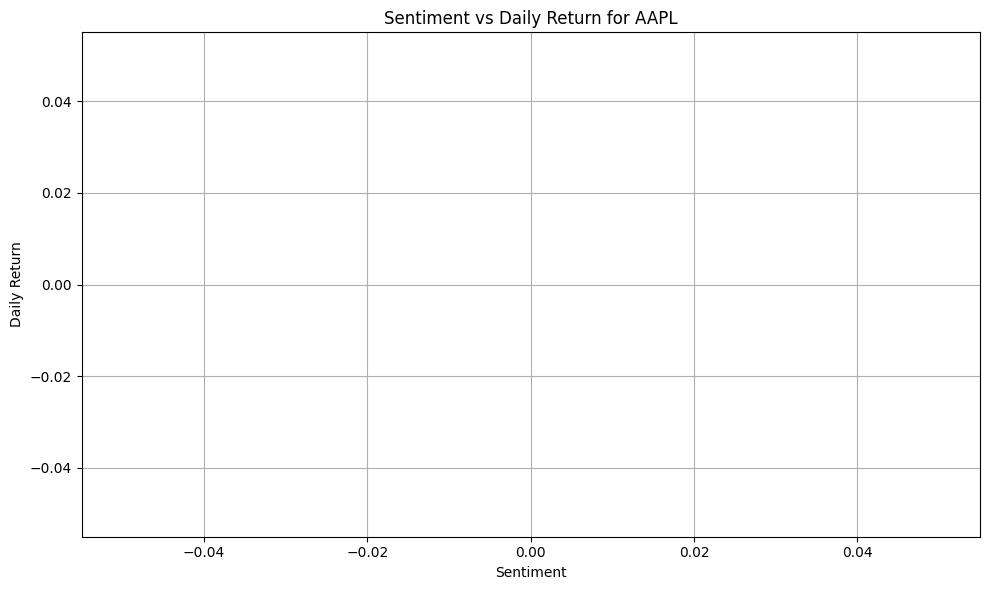

d:\KAIM\Week0_12\Week_1\AIM_Week_1\.venv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
d:\KAIM\Week0_12\Week_1\AIM_Week_1\.venv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


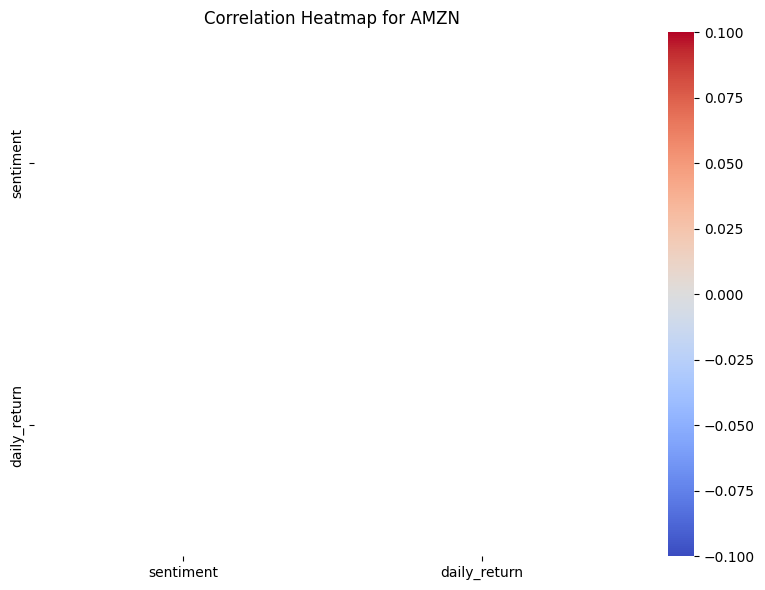

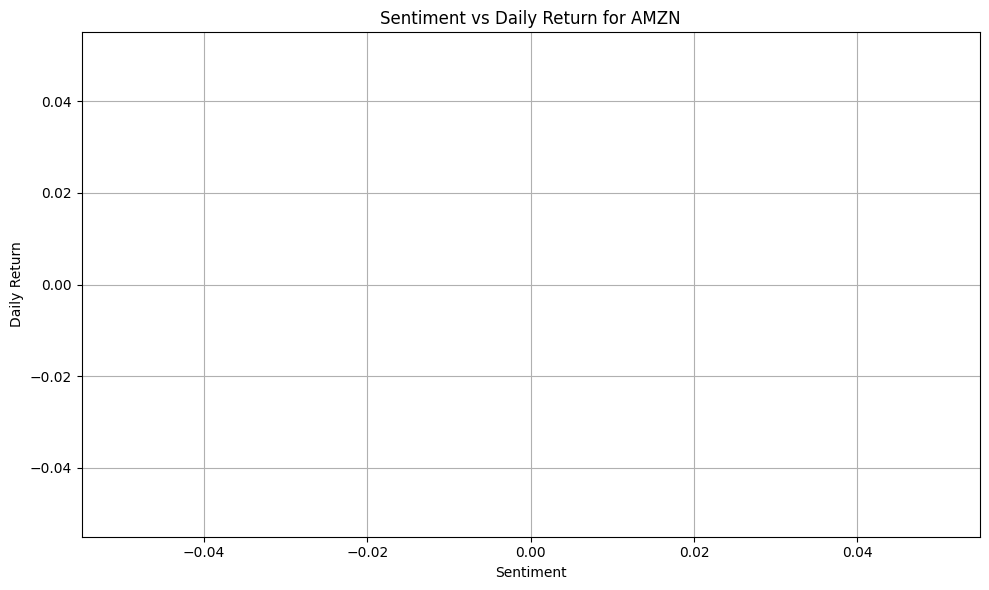

In [8]:
def process_data(stock_file, news_file):
    # Load datasets
    news_df = pd.read_csv(news_file)
    stock_df = pd.read_csv(stock_file)

    # Convert to datetime
    news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')
    stock_df['Date'] = pd.to_datetime(stock_df['Date'], errors='coerce')

    # Remove timezone if present
    if news_df['date'].dt.tz is not None:
        news_df['date'] = news_df['date'].dt.tz_localize(None)
    if stock_df['Date'].dt.tz is not None:
        stock_df['Date'] = stock_df['Date'].dt.tz_localize(None)

    # Drop rows with invalid dates
    news_df.dropna(subset=['date'], inplace=True)
    stock_df.dropna(subset=['Date'], inplace=True)

    # Sentiment analysis
    analyzer = SentimentIntensityAnalyzer()
    news_df['sentiment'] = news_df['headline'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])

    # Aggregate sentiment
    daily_sentiment = news_df.groupby('date')['sentiment'].mean().reset_index()

    # Calculate daily returns
    stock_df['daily_return'] = stock_df['Close'].pct_change()
    stock_df.dropna(subset=['daily_return'], inplace=True)

    # Merge on date
    merged_df = pd.merge(daily_sentiment, stock_df, left_on='date', right_on='Date', how='inner')

    # Correlation
    correlation = merged_df[['sentiment', 'daily_return']].corr().iloc[0, 1]

    return correlation, daily_sentiment, stock_df, merged_df



def visualize_results(results, sentiment_data, returns_data, merged_data_dict):
    # Summary correlation bar chart
    summary_df = pd.DataFrame(results.items(), columns=['Stock', 'Correlation'])
    print("\nSummary of Correlations:\n", summary_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Stock', y='Correlation', data=summary_df, palette='viridis')
    plt.title('Sentiment vs Daily Return Correlation')
    plt.xlabel('Stock')
    plt.ylabel('Correlation')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Time-series sentiment plots
    for stock, data in sentiment_data.items():
        plt.figure(figsize=(12, 6))
        plt.plot(data['date'], data['sentiment'], label='Sentiment', color='blue')
        plt.title(f'Daily Sentiment for {stock}')
        plt.xlabel('Date')
        plt.ylabel('Sentiment Score')
        plt.grid(True)
        plt.legend()
        plt.show()

    # Time-series return plots
    for stock, data in returns_data.items():
        plt.figure(figsize=(12, 6))
        plt.plot(data['Date'], data['daily_return'], label='Daily Return', color='red')
        plt.title(f'Daily Return for {stock}')
        plt.xlabel('Date')
        plt.ylabel('Return')
        plt.grid(True)
        plt.legend()
        plt.show()

    # Correlation heatmaps and scatter plots
    for stock, data in merged_data_dict.items():
        plt.figure(figsize=(8, 6))
        sns.heatmap(data[['sentiment', 'daily_return']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
        plt.title(f'Correlation Heatmap for {stock}')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.scatter(data['sentiment'], data['daily_return'], alpha=0.5, color='purple')
        plt.title(f'Sentiment vs Daily Return for {stock}')
        plt.xlabel('Sentiment')
        plt.ylabel('Daily Return')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# Main execution
stock_files = {
    'GOOG': '../data/GOOG_historical_data.csv',
    'META': '../data/META_historical_data.csv',
    'MSFT': '../data/MSFT_historical_data.csv',
    'NVDA': '../data/NVDA_historical_data.csv',
    'AAPL': '../data/AAPL_historical_data.csv',
    'AMZN': '../data/AMZN_historical_data.csv',
}

news_file = '../data/raw_analyst_ratings.csv'

# Initialize containers
results = {}
sentiment_data = {}
returns_data = {}
merged_data_dict = {}

# Process each stock
for stock, file in stock_files.items():
    corr, sentiment_df, stock_df, merged_df = process_data(file, news_file)
    results[stock] = corr
    sentiment_data[stock] = sentiment_df
    returns_data[stock] = stock_df
    merged_data_dict[stock] = merged_df

# Visualize results
visualize_results(results, sentiment_data, returns_data, merged_data_dict)
